In [147]:
import pandas as pd
import ast as ast
import numpy as np
from typing import *
import seaborn as sns
import matplotlib.pyplot as plt
from task_2_helpers import *
from transformers import pipeline

### Data Read

In [148]:
# df_business = pd.read_parquet("data/ATML2024_businesses.parquet")
df_business = pd.read_csv("data/ATML2024_businesses.csv", header=0)

# df_Train_reviews = pd.read_parquet("data/ATML2024_reviews_train.parquet")
df_Train_reviews = pd.read_csv("data/ATML2024_reviews_train.csv", header=0)

# df_users = pd.read_parquet("data/ATML2024_users.parquet")
df_users = pd.read_csv("data/ATML2024_users.csv", header=0)

### Cleanup business data columns

In [149]:
# @@@@ Run only once
# Keep only observation business in Philadelphia
bussiness_city = ["Phila","Philadelphia", "Philadelphia", "Philadelphia (Northeast Philly)", "Philadelphia PA", "Philadelphila", "Philadephia", "Philiadelphia", 
"Philiidelphia", "Philly", "Southwest Philadelphia", "West Philadelphia", "philadelphia", "PHILA", "PHILADELPHIA"]
df_business = df_business[df_business["city"].isin(bussiness_city)]
df_business = df_business[df_business["state"] == "PA"]

# Convert dictionary columns to the correct types
df_business["attributes"] = df_business["attributes"].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())
df_business["hours"] = df_business["hours"].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())

# Extract values from dictionary columns
df_business["hours_list"] = df_business["hours"].apply(lambda x: extract_hours_value(x))
df_business["attributes_list"] = df_business["attributes"].apply(lambda x: sorted(extract_attributes_value(x)))
df_business["categories_list"] = df_business["categories"].apply(lambda x: sorted(map(lambda a: a.strip().lower(),  x.split(",")) ) if isinstance(x, str) else [])

# Join Business Data With Ratings Data
df_business_data = df_business[["business_id", "postal_code", "attributes_list", "hours_list", "categories_list"]]
df_ratings_data = df_Train_reviews[["business_id", "user_id", "rating", "useful", "funny", "cool", "text"]]

df_data = pd.merge(df_business_data, df_ratings_data, left_on= "business_id", right_on="business_id")
# Keep only values with "restaurants"
df_data = df_data[df_data["categories_list"].apply(lambda x: any("restaurants" in str(a).lower() for a in x))]

### Cleaning categories based on frequency

In [150]:
# Removing categories with less than 5% of the total data
business_cat = np.concatenate(df_data.categories_list.values).ravel()
c = Counter(business_cat)
df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]                                              
data_ratings =  df_data_res[['categories_list', 'rating']]
data_cat_rating_single = data_ratings.explode('categories_list')

data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rate_freq_ratio'] = data_cat_rating_single['frequency']/len(data_cat_rating_single)

data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rate_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}) 

# Keeping only frequent categories using the lower quartile as threshold.
data_cat_rare = set(data_cat[(data_cat['rate_freq_ratio'] <= data_cat['rate_freq_ratio'].describe()[4]) ]["categories"])
data_cat[(data_cat['rate_freq_ratio'] < data_cat['rate_freq_ratio'].describe()[4]) ]["categories"].head(10)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\1086952276.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_cat_rare = set(data_cat[(data_cat['rate_freq_ratio'] <= data_cat['rate_freq_ratio'].describe()[4]) ]["categories"])
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\1086952276.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_cat[(data_cat['rate_freq_ratio'] < data_cat['rate_freq_ratio'].describe()[4]) ]["categories"].head(10)


1721     it services & computer repair
1721                    souvenir shops
5682                            hainan
6108                            tennis
7011                           jewelry
7387                      distilleries
11315                 wholesale stores
13498                   swimming pools
14482              eyewear & opticians
16869            cannabis dispensaries
Name: categories, dtype: object

We drop rare categories based on the lower quartile. We note that strange and weird categories have been removed which should improve the quality of the analysis.

In [151]:
# Removing attributes with less than 5% of the total data
data_ratings =  df_data_res[['attributes_list', 'rating']]
data_attr_rating_single = data_ratings.explode('attributes_list')

data_attr_rating_single['mean_rating'] = data_attr_rating_single[['attributes_list', 'rating']]\
                        .groupby('attributes_list')['rating'].transform('mean')

data_attr_rating_single['frequency'] = data_attr_rating_single['attributes_list'].map(data_attr_rating_single['attributes_list'].value_counts())
data_attr_rating_single['rate_freq_ratio'] = data_attr_rating_single['frequency']/len(data_attr_rating_single)

data_attr = data_attr_rating_single[['attributes_list', 'frequency', 'mean_rating', 'rate_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes'}) 

# Keeping only frequent attributes using the lower quartile as threshold.
data_attr_rare = set(data_attr[(data_attr['rate_freq_ratio'] <= data_attr['rate_freq_ratio'].describe()[4]) ]["attributes"])
data_attr[(data_attr['rate_freq_ratio'] <= data_attr['rate_freq_ratio'].describe()[4]) ]["attributes"]

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2421343643.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_attr_rare = set(data_attr[(data_attr['rate_freq_ratio'] <= data_attr['rate_freq_ratio'].describe()[4]) ]["attributes"])
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2421343643.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_attr[(data_attr['rate_freq_ratio'] <= data_attr['rate_freq_ratio'].describe()[4]) ]["attributes"]


16869              AcceptsInsurance
32778                   Open24Hours
95780           DietaryRestrictions
123856    RestaurantsCounterService
140268                  AgesAllowed
144147                    DriveThru
144548            ByAppointmentOnly
144622                    CoatCheck
144622                      Smoking
144921                         BYOB
Name: attributes, dtype: object

We drop rare attributes based on the lower quartile. We have above the list of uncommon attributes.

#### Applying sentiment analysis on reviews

In [152]:
# Load NLP models
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing TFBartForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForS

We will use 2 NLP models. Sentiment analysis we wil be performed using "distilbert-base-uncased-finetuned-sst-2-english" (has 67M params and  an acccuracy of 91% on validation set from an evaluation benchmark according to HuggingFace.) as it is a light model with good accuracy on english text. With respect to classification, we will use "facebook/bart-large-mnli" (407M params) as it is known to be a good model (seen during seminar) to evaluate if a sequence belongs to a given class.

In [153]:
# Find quantity of reviews with more 375 tokens
df_data["token"] = df_data["text"].apply(lambda x: len(x.split(" ")))
df_data[df_data["token"] >= 375].shape[0] / df_data.shape[0]
df_data["token"].describe()

# Split the dataset up to 3 parts of 125 tokens each
df_1 = df_data[(df_data["token"] >= 1) & (df_data["token"] <= 125)]
df_2 = df_data[(df_data["token"] >= 126) & (df_data["token"] <= 250)]
df_3 = df_data[(df_data["token"] >= 251) & (df_data["token"] <= 375)]

# Write in new columns the tokens
df_2["token_1"] = df_2["text"].apply(lambda x: " ".join(x.split()[:125]))
df_2["token_2"] = df_2["text"].apply(lambda x: " ".join(x.split()[125:250]))

df_3["token_1"] = df_3["text"].apply(lambda x: " ".join(x.split()[:125]))
df_3["token_2"] = df_3["text"].apply(lambda x: " ".join(x.split()[125:250]))
df_3["token_3"] = df_3["text"].apply(lambda x: " ".join(x.split()[250:375]))

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3160575853.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["token_1"] = df_2["text"].apply(lambda x: " ".join(x.split()[:125]))
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3160575853.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["token_2"] = df_2["text"].apply(lambda x: " ".join(x.split()[125:250]))
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3160575853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [154]:
# To do: removed 
df_1 = df_1[:200]
df_2 = df_2[:200]
df_3 = df_3[:200]

# To do: Move to Helper
def sentiment(text):
    output = sent_pipe(text)[0]["label"]
    return output

# Assign sentiments based on reviews 
df_1["sentiment"] = df_1["text"].apply(sentiment)
df_2["sentiment_1"] = df_2["token_1"].apply(sentiment)
df_2["sentiment_2"] = df_2["token_2"].apply(sentiment)
df_3["sentiment_1"] = df_3["token_1"].apply(sentiment)
df_3["sentiment_2"] = df_3["token_2"].apply(sentiment)
df_3["sentiment_3"] = df_3["token_3"].apply(sentiment)

# Extract the final sentiment (voted)
df_2["sentiment"] = df_2[["sentiment_1", "sentiment_2"]].mode(axis=1)[0]
df_3["sentiment"] = df_3[["sentiment_1", "sentiment_2","sentiment_3"]].mode(axis=1)[0]

# Drop columns
df_2 = df_2.drop(columns=["token_1", "sentiment_1", "token_2", "sentiment_2"])
df_3 = df_3.drop(columns=["token_1", "sentiment_1", "token_2", "sentiment_2","token_3", "sentiment_3"])

# Unify the datasets
df_data = pd.concat([df_1, df_2, df_3], ignore_index=True)
df_data.head()
df_data_full = df_data.copy()

Since models are often limited to 128 tokens, we circumvent this problem by applying sentiment analysis several times. To do this, we separate the text into slices of 125 tokens and apply a voting (using the mode) system to elect a final sentiment per review.

## 2.1  An insight on what restaurant consumers generally seem to like (for example in terms of food, service, location, etc...).

## Insights based on logical metrics (ratings and distribution)

In [155]:
# All categories in a set
all_categories = set(np.concatenate(df_data.categories_list.values).ravel()) #df_data.categories_list.values.flatten()

# Replace list by unique (individualize /create new rows) 
categories_individ_df = df_data.explode("categories_list")
categories_individ_df = categories_individ_df[categories_individ_df["categories_list"] != "restaurants"]
categories_individ_df = categories_individ_df[categories_individ_df["categories_list"] != "food"]

# Remove reviews with rare categories
categories_individ_df = categories_individ_df[~categories_individ_df['categories_list'].isin(data_cat_rare)]

In [156]:
# Define the groups
group_names = ["Ambiance", "Location", "Service Style", "Meal Type", "Type of Cuisine" ]

# Initialize empty dictionary used to map group labels per category item
CategoryLabel = {}

# Assign a group to categories
for category in all_categories:
    output = classifier(category, group_names)
    CategoryLabel[category] = output["labels"][0]

# Mapping the group to the categories
categories_individ_df["group_categorie"] = categories_individ_df["categories_list"].map(CategoryLabel)

We use the classification model to assign each category a broader group name. 

#### Frequency of items in Attributes

In [157]:
# Remove categories appearing less than 10 times
categories_individ_df = categories_individ_df.groupby("categories_list").filter(lambda x: len(x) > 10)

In [158]:
# See the distribution of ratings
categories_individ_df["rating"].describe()

count    1983.000000
mean        3.648008
std         1.319020
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\991362231.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")


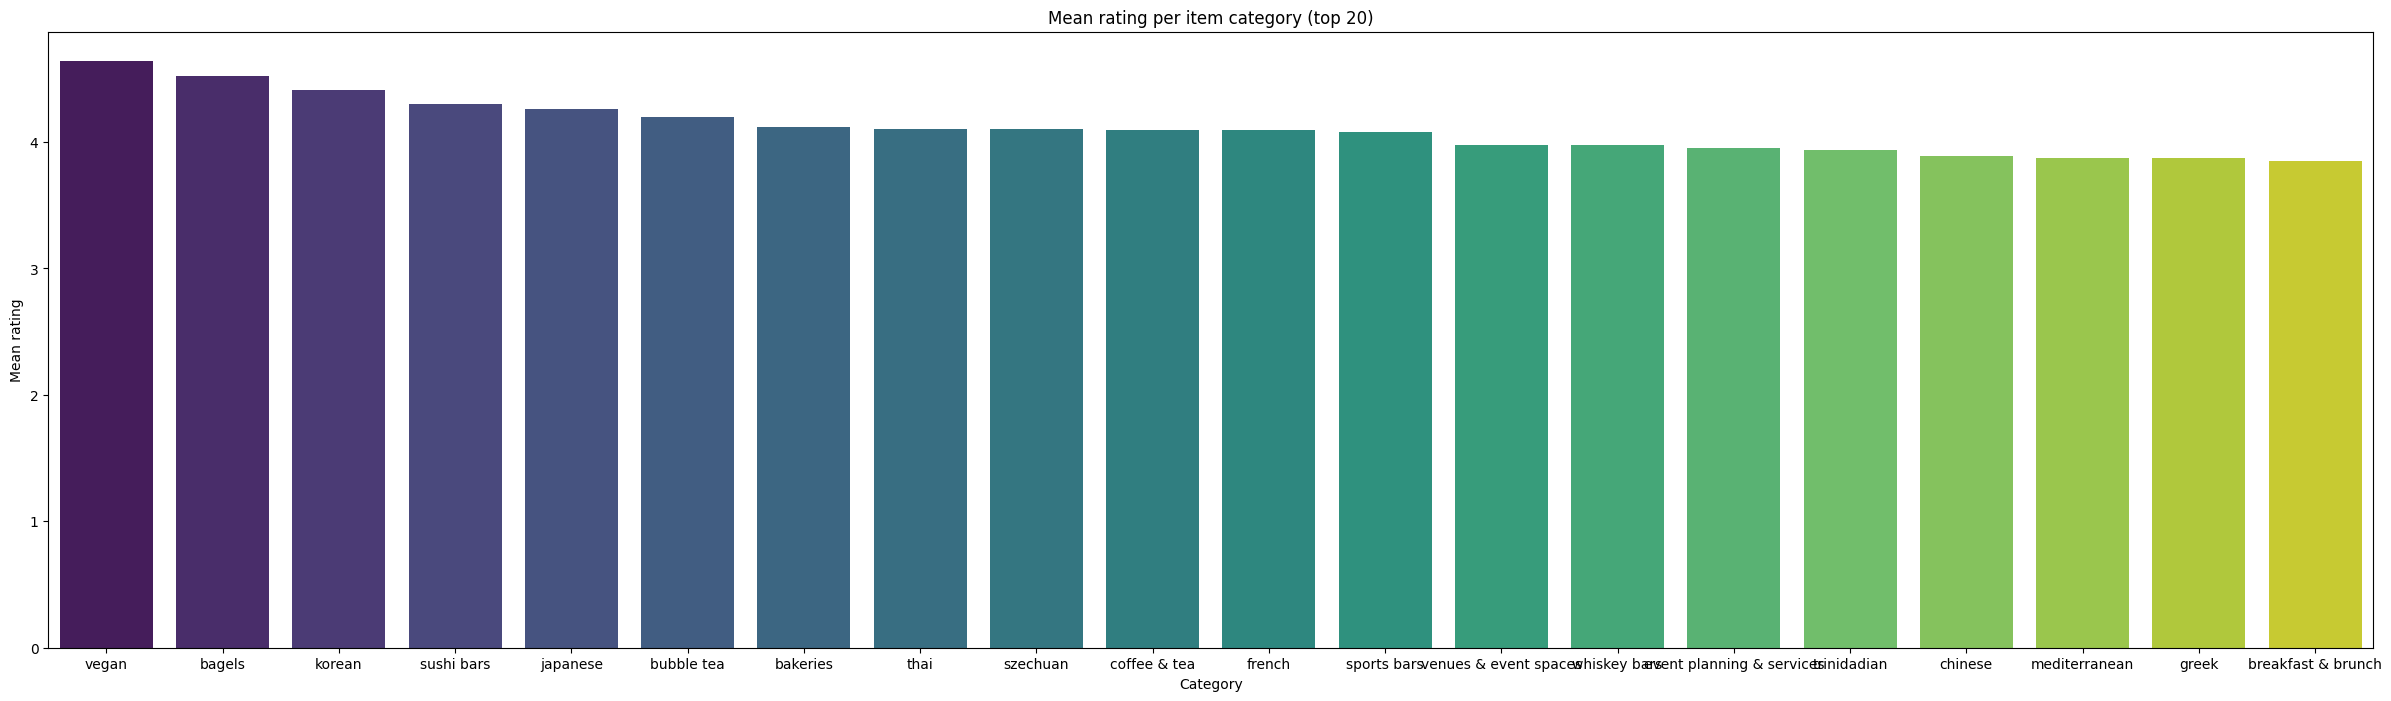

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\991362231.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")


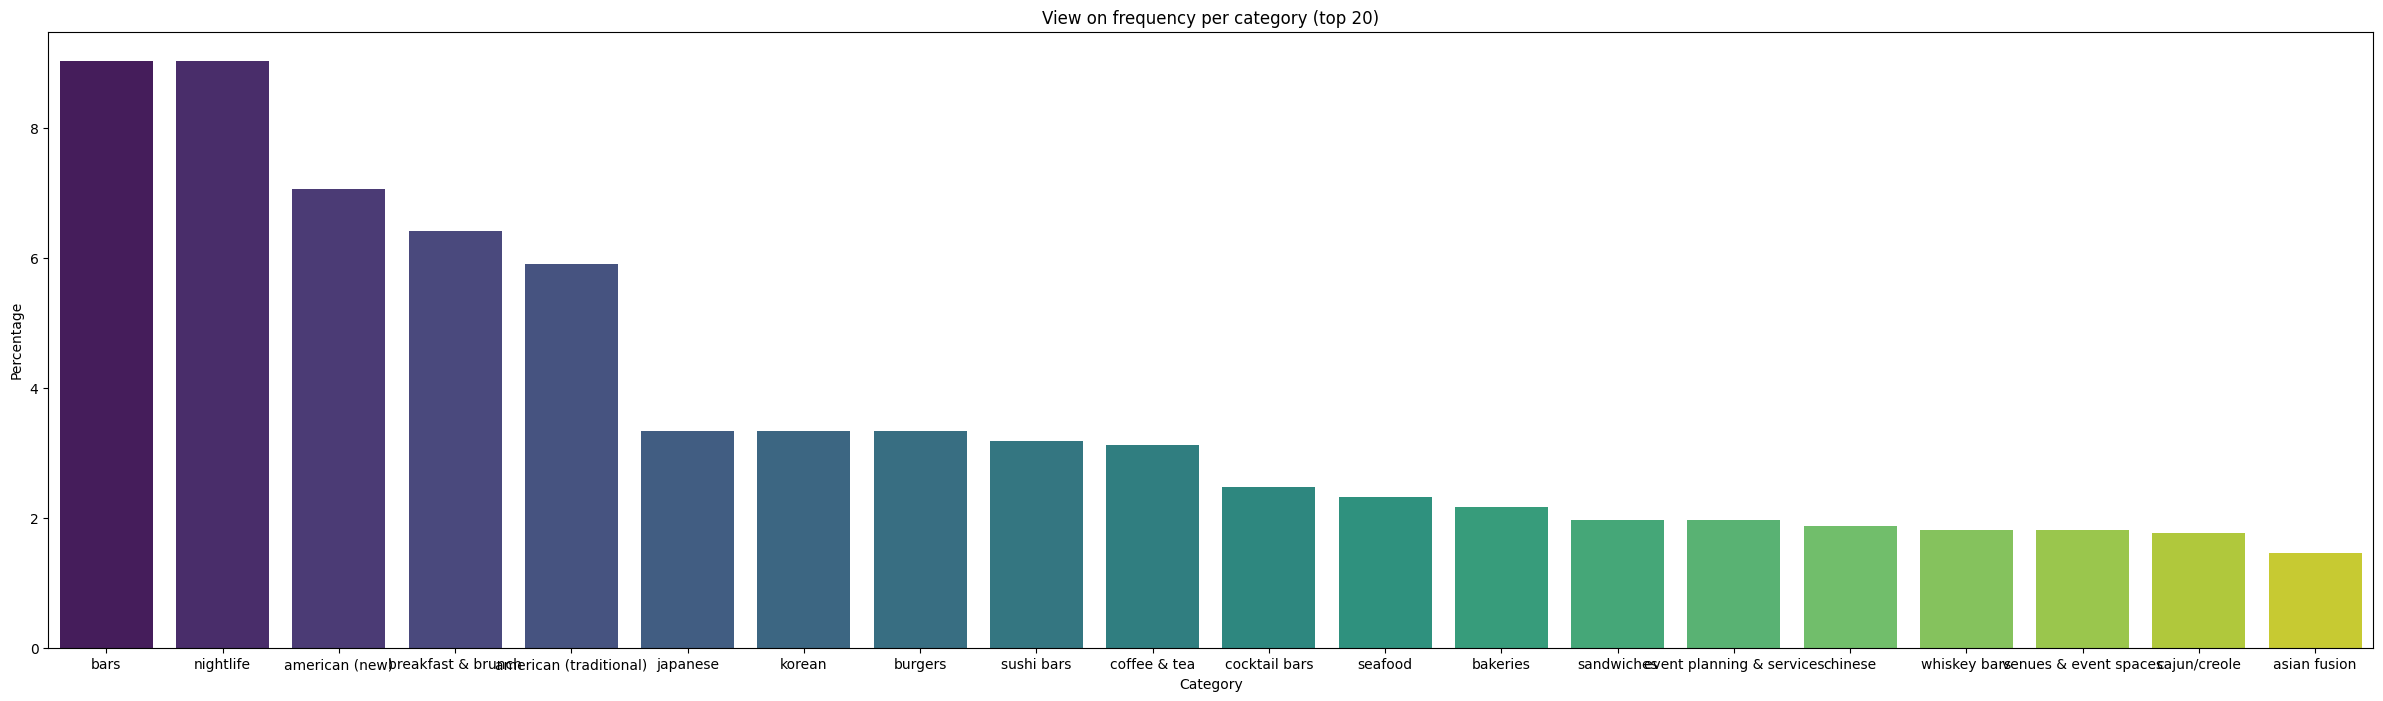

In [159]:
############################################################
# Averaging the ratings per category

# Plot
mean_ratings = categories_individ_df.groupby("categories_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 8))
plt.title("Mean rating per item category (top 20)")
sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Mean rating")
plt.show()

############################################################
# Percentage per category
category_counts = categories_individ_df["categories_list"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ["category", "percentage"]
plt.figure(figsize=(30, 8))
plt.title("View on frequency per category (top 20)")
sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.show()

#### PLOT PER GROUP CATEGORY

In [160]:
# Mean rating per category
mean_ratings["group_category"] = mean_ratings["categories_list"].map(CategoryLabel)
mean_ratings = mean_ratings.groupby(["group_category", "categories_list"])["rating"].mean().reset_index()
mean_ratings[mean_ratings["rating"] >= 4].sort_values(by=["group_category","rating", ], ascending=[False, False]).head(15)

,group_category,categories_list,rating
44,Type of Cuisine,korean,4.409091
48,Type of Cuisine,sushi bars,4.301587
43,Type of Cuisine,japanese,4.257576
50,Type of Cuisine,thai,4.105263
49,Type of Cuisine,szechuan,4.100000
40,Type of Cuisine,french,4.090909
29,Meal Type,vegan,4.640000
16,Meal Type,bagels,4.518519
17,Meal Type,bakeries,4.116279
22,Meal Type,coffee & tea,4.096774


C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3232981077.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


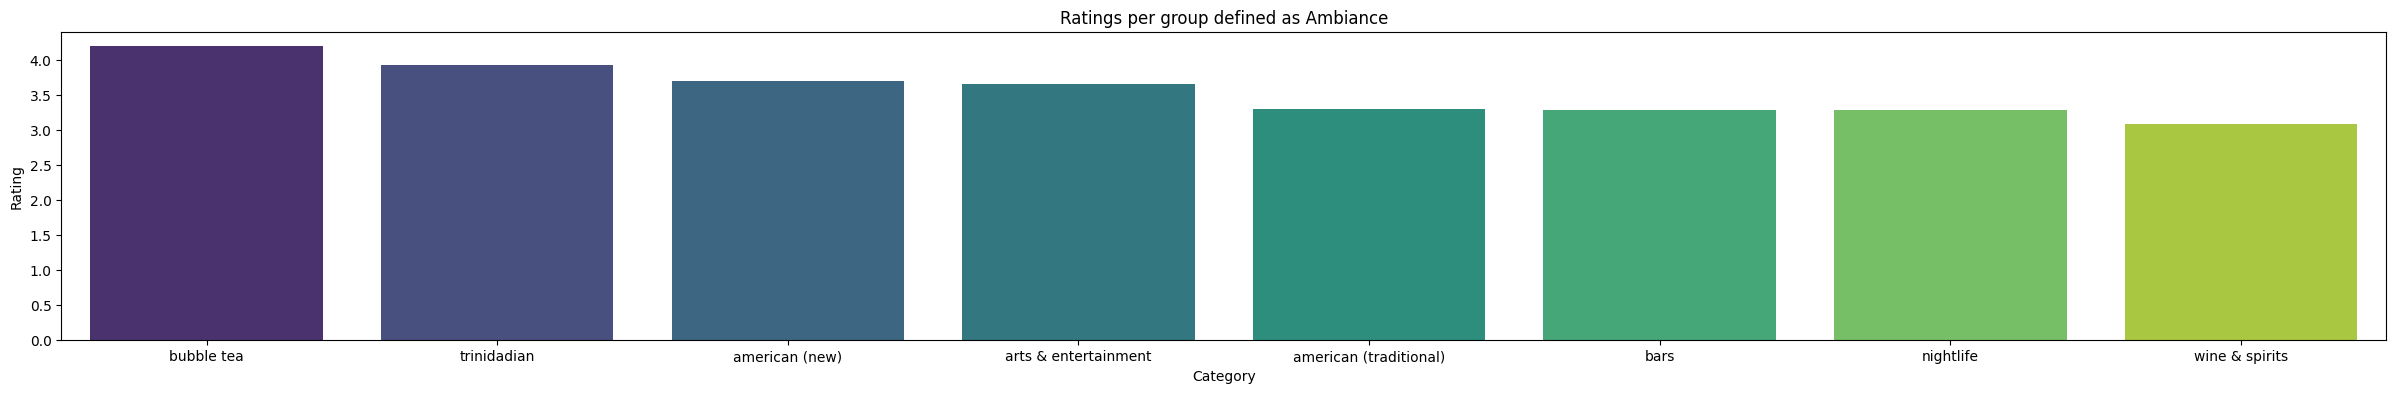

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3232981077.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


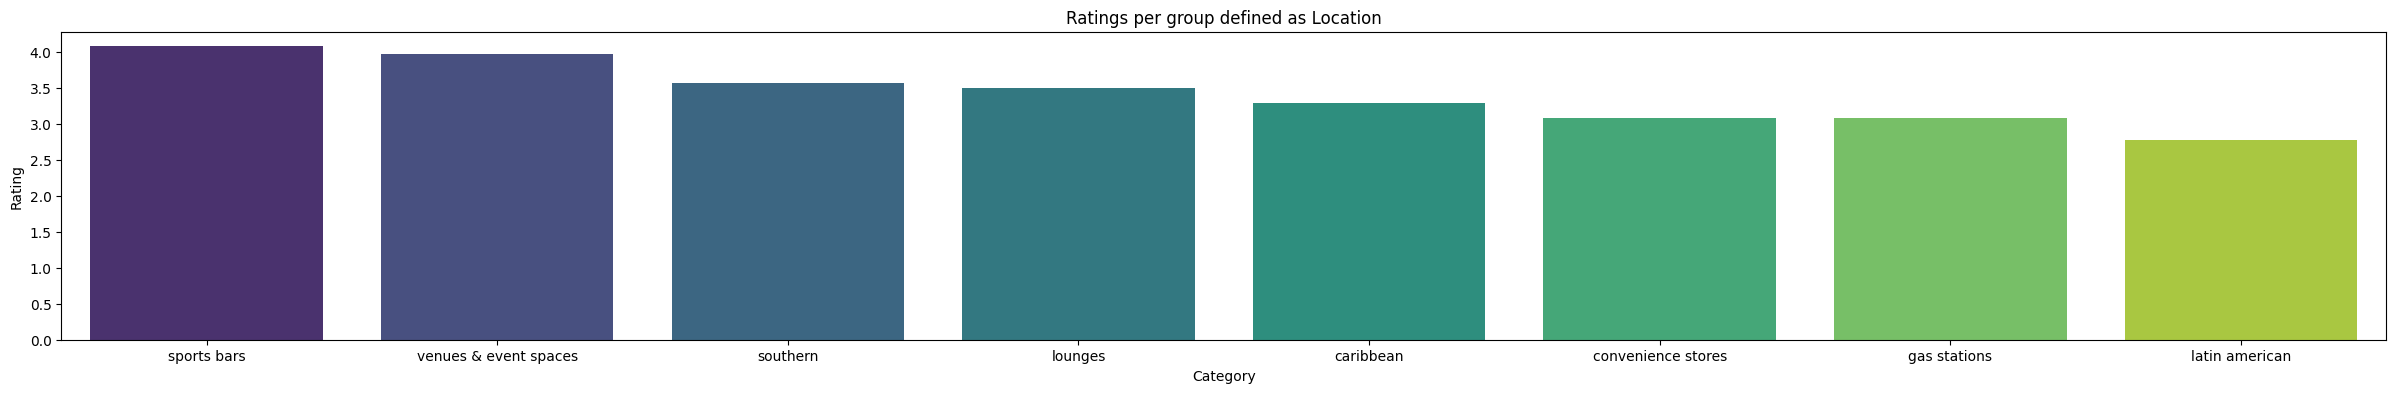

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3232981077.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


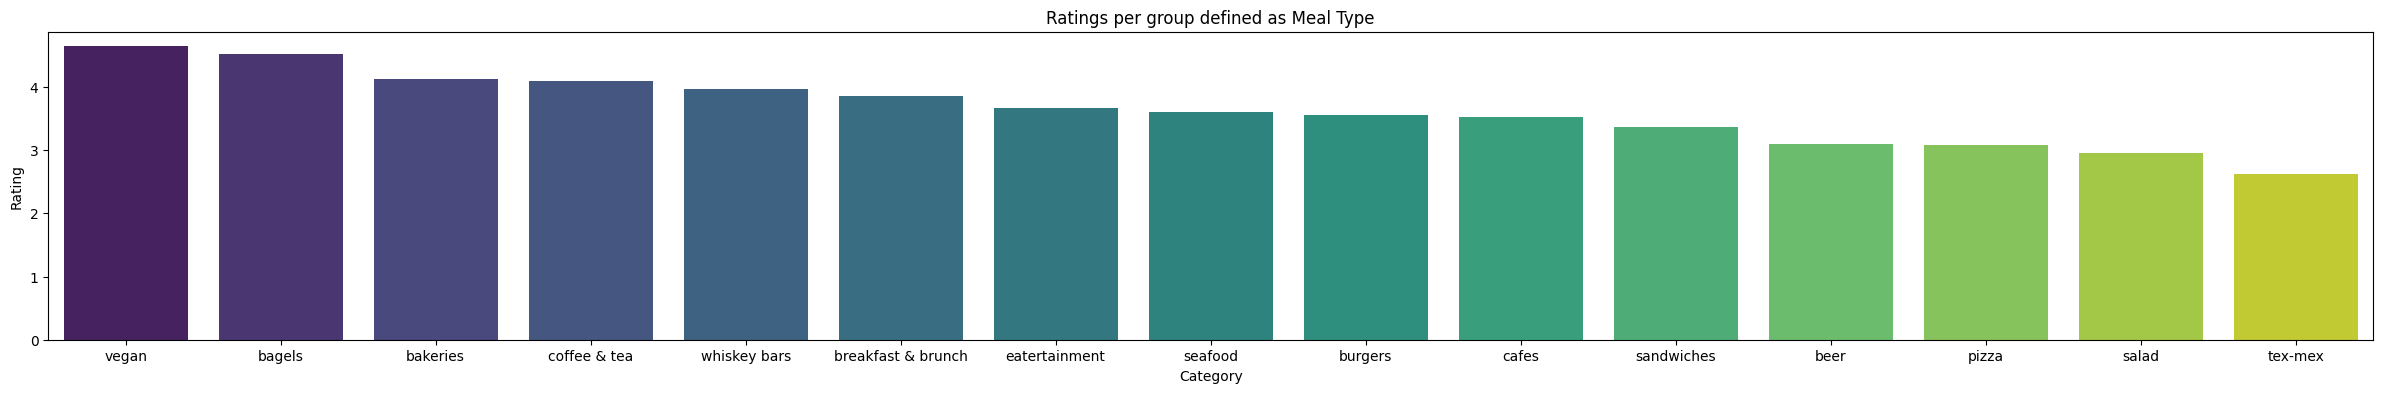

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3232981077.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


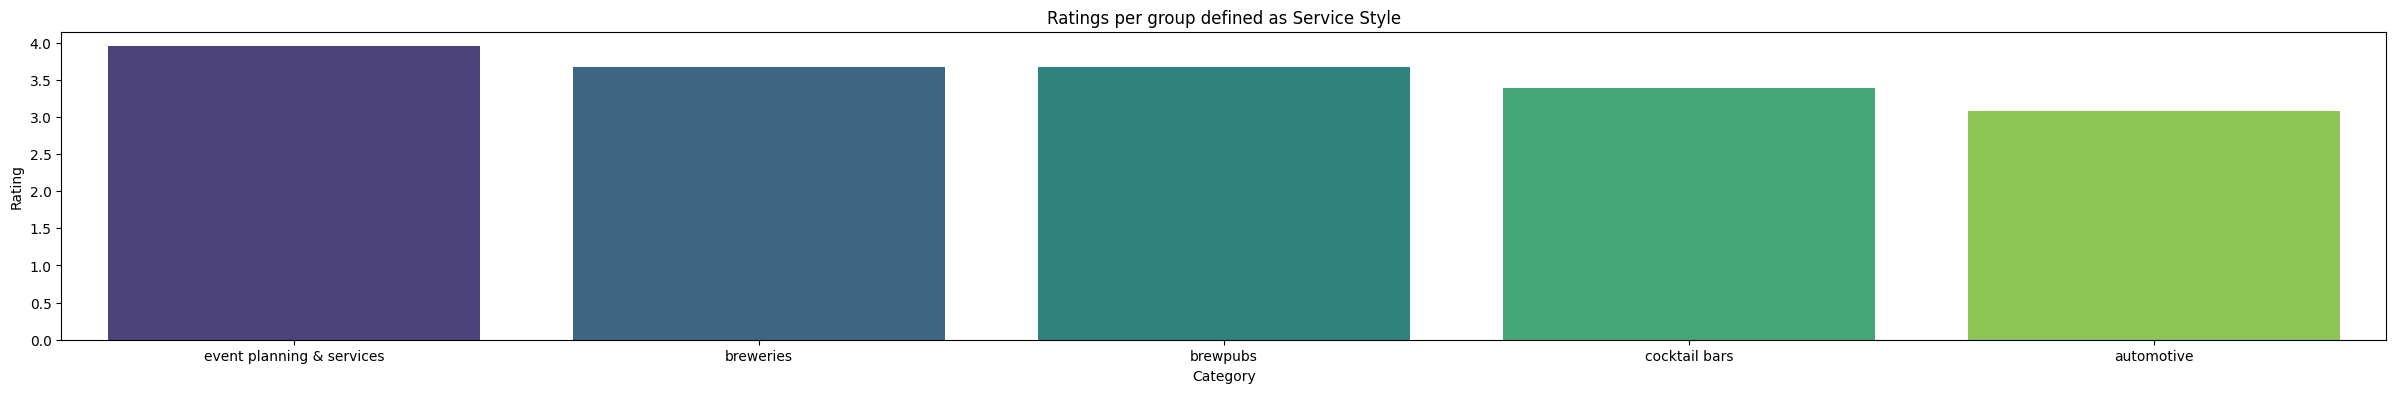

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3232981077.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


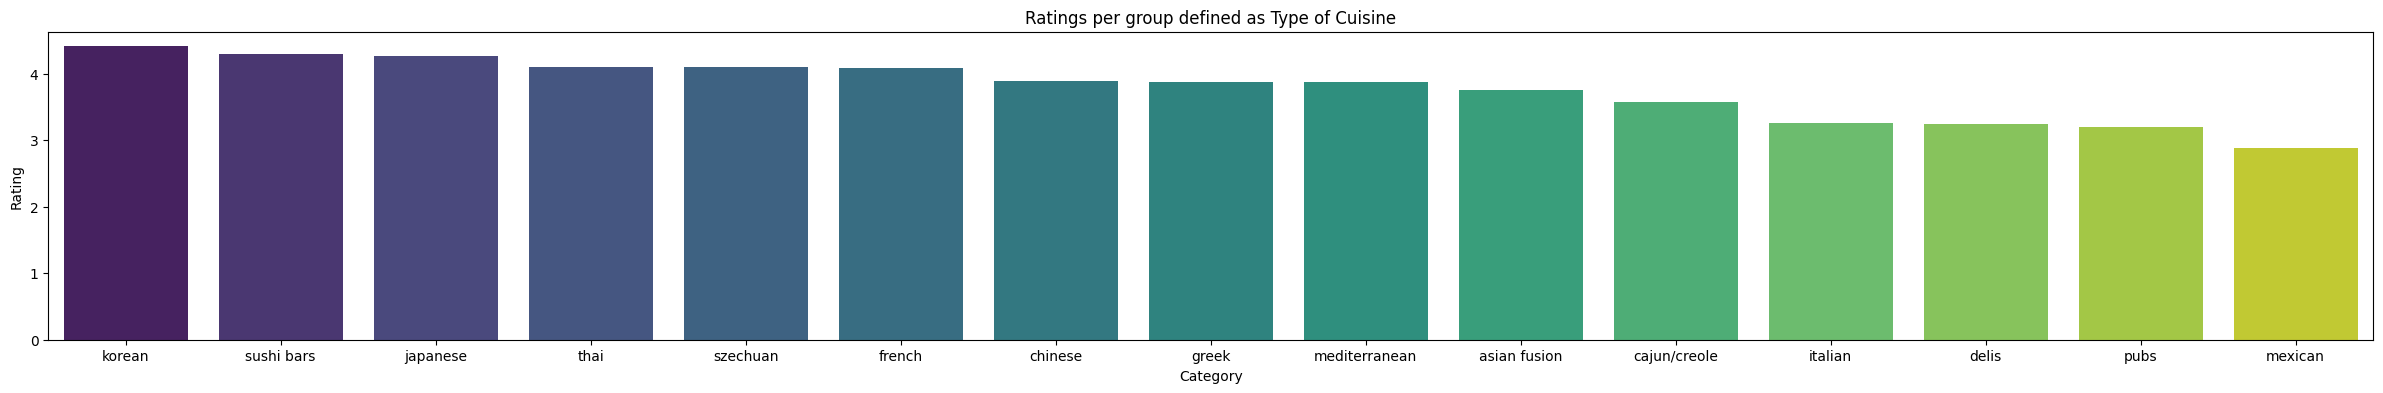

In [161]:
# Bar plots per group
for group in mean_ratings["group_category"].unique():
    df_ft = mean_ratings[mean_ratings["group_category"] == group]
    df_ft[["categories_list", "rating"]]
    df_ft = df_ft.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Ratings per group defined as {group}")
    sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Rating")
    plt.show()

#### Replicating steps above for category by keeping reviews judged useful at least 2 times

We can apply a filtering on the reviews to keep only the ones that have been judged "useful" and see how this new constraint affect the rankings. We need to keep the threshold low to keep a lot of reviews and getting a representative view without excluding business with few reviews, but also high enough to perform a qualitative distinguishment with respect to the previous outputs. We chose therefore to exclude reviews having not been judged useful or have been judged useful only once.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\271192542.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")


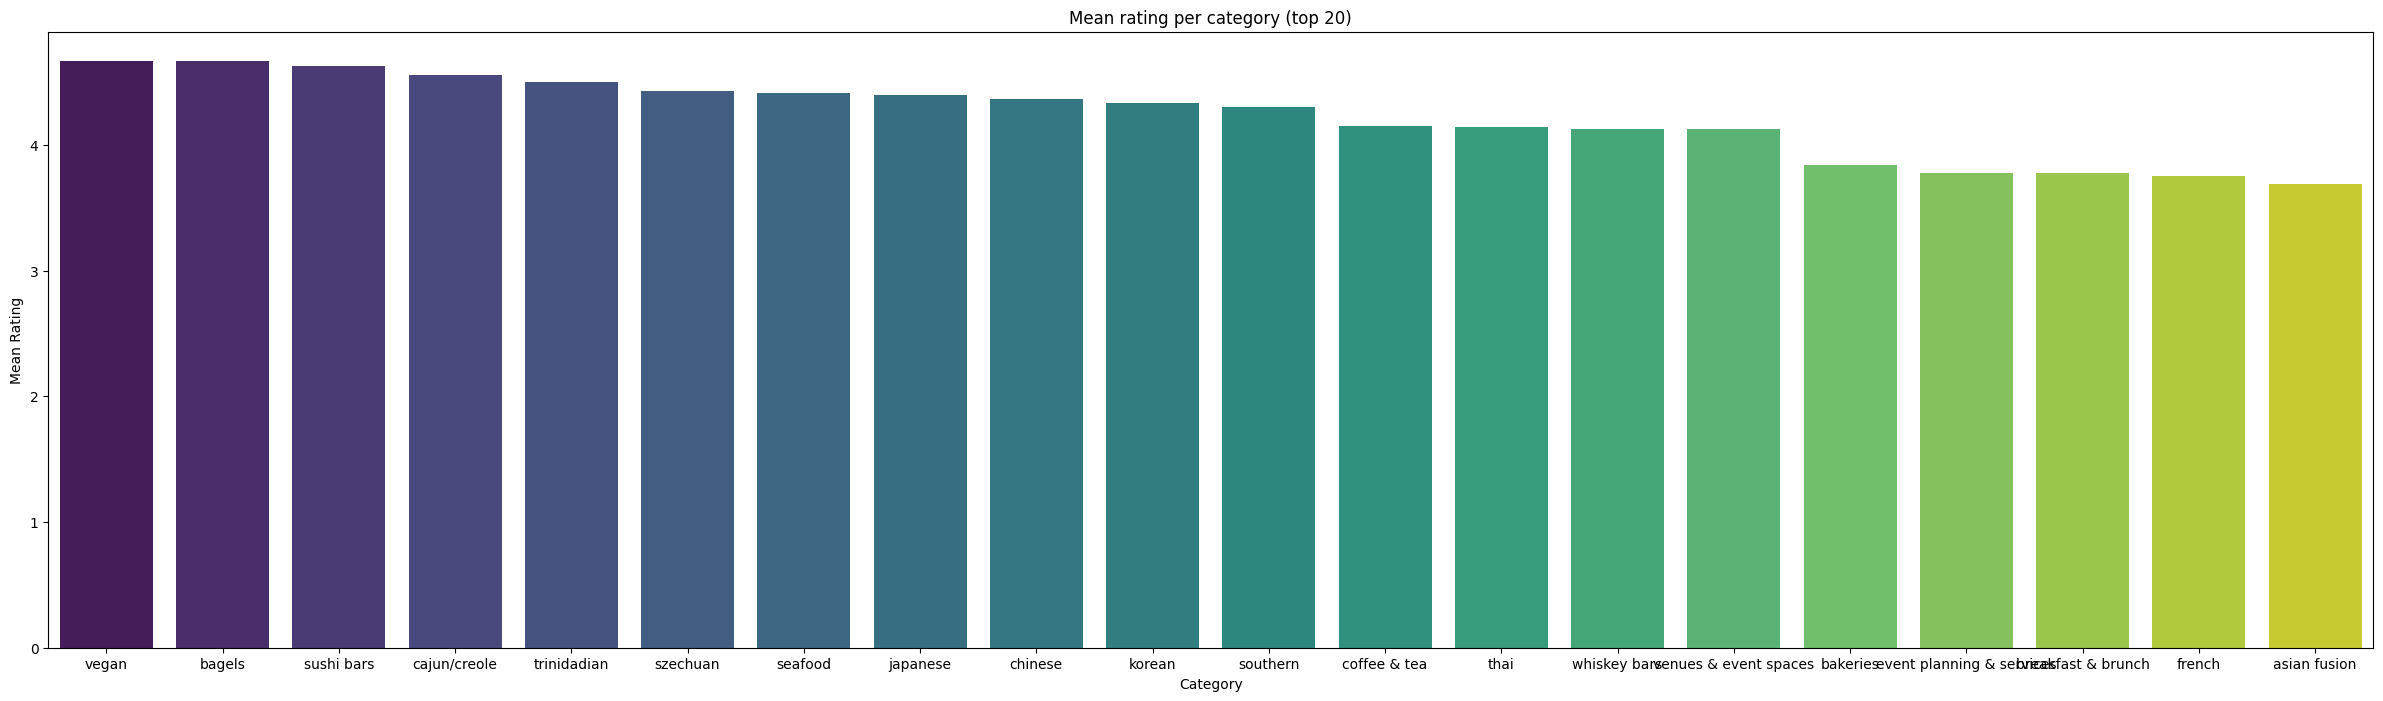

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\271192542.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")


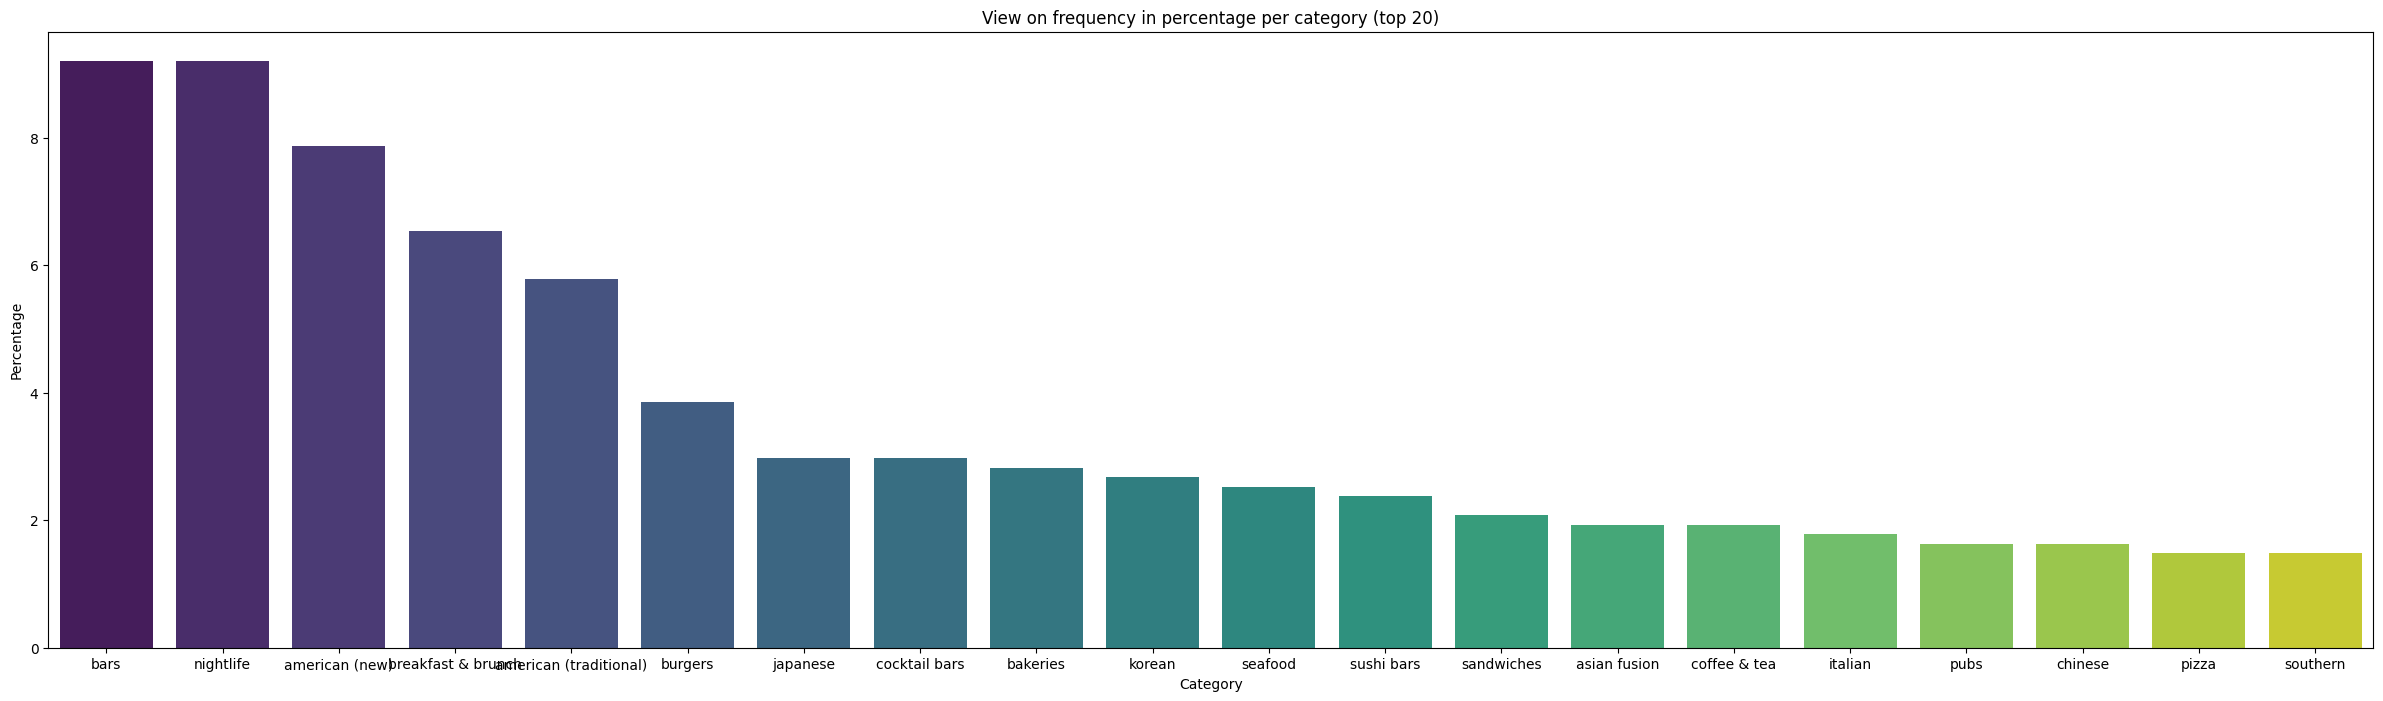

In [162]:
# Keep score in useful >= 2
df_data_utility = categories_individ_df[categories_individ_df["useful"] >= 2]

# Percentage
category_counts = df_data_utility["categories_list"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100


# Plot
mean_ratings = df_data_utility.groupby("categories_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 8))
plt.title("Mean rating per category (top 20)")
sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Mean Rating")
plt.show()


# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ["category", "percentage"]
plt.figure(figsize=(30, 8))
sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")
plt.title("View on frequency in percentage per category (top 20)")
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.show()

The ranking changes when we filter the comments to keep only those useful. We can play with the importance assigned to some reviews by assigning a threshold value to their usefulness. This makes it possible to filter by keeping reviews important to the public opinion.

## Replicating steps above for attributes (no filter on "useful")

In [163]:
# Reinitializing the dataset
df_data = df_data_full.copy()
# Split the dataset per attribute and remove observations with rare attributes
attribute_individ_df = df_data.explode("attributes_list")
attribute_individ_df = attribute_individ_df[~attribute_individ_df["attributes_list"].isin(data_attr_rare)]
attribute_counts = attribute_individ_df["attributes_list"].value_counts()
attribute_counts

# Put attributes in a set
all_attributes = set(np.concatenate(df_data.attributes_list.values).ravel())
df_data.attributes_list.values

{'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi'}

In [164]:
# Group attributes  
group_names = ["Pricing", "Service Style", "Location", "Beverage", "Meal Times", "Amenities"]
Attribute_groups = {}

# Classify the attributes according to the groups
for category in all_attributes:
    output = classifier(category, group_names)
    Attribute_groups[category] = output["labels"][0]

attribute_individ_df["group_attribute"] = attribute_individ_df["attributes_list"].map(Attribute_groups)

#### Frequency of items in attributes

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2269721541.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")


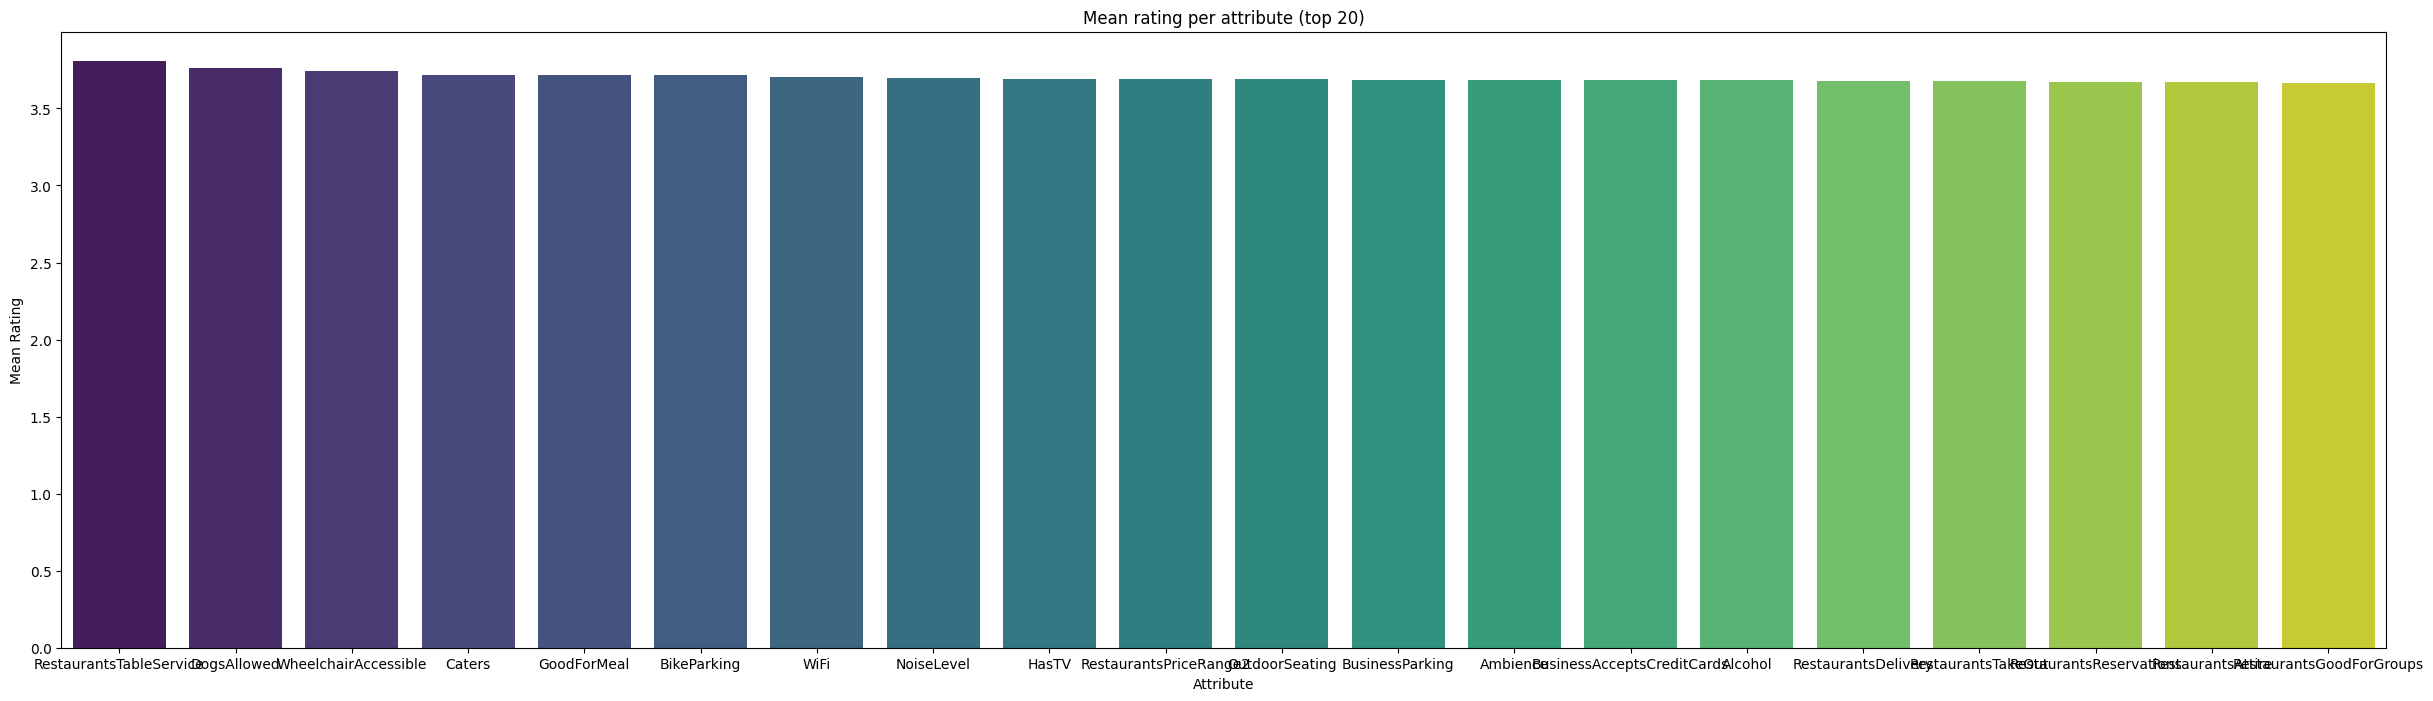

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2269721541.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes", y="percentage", data=attribute_percentages_df[:20], palette="viridis")


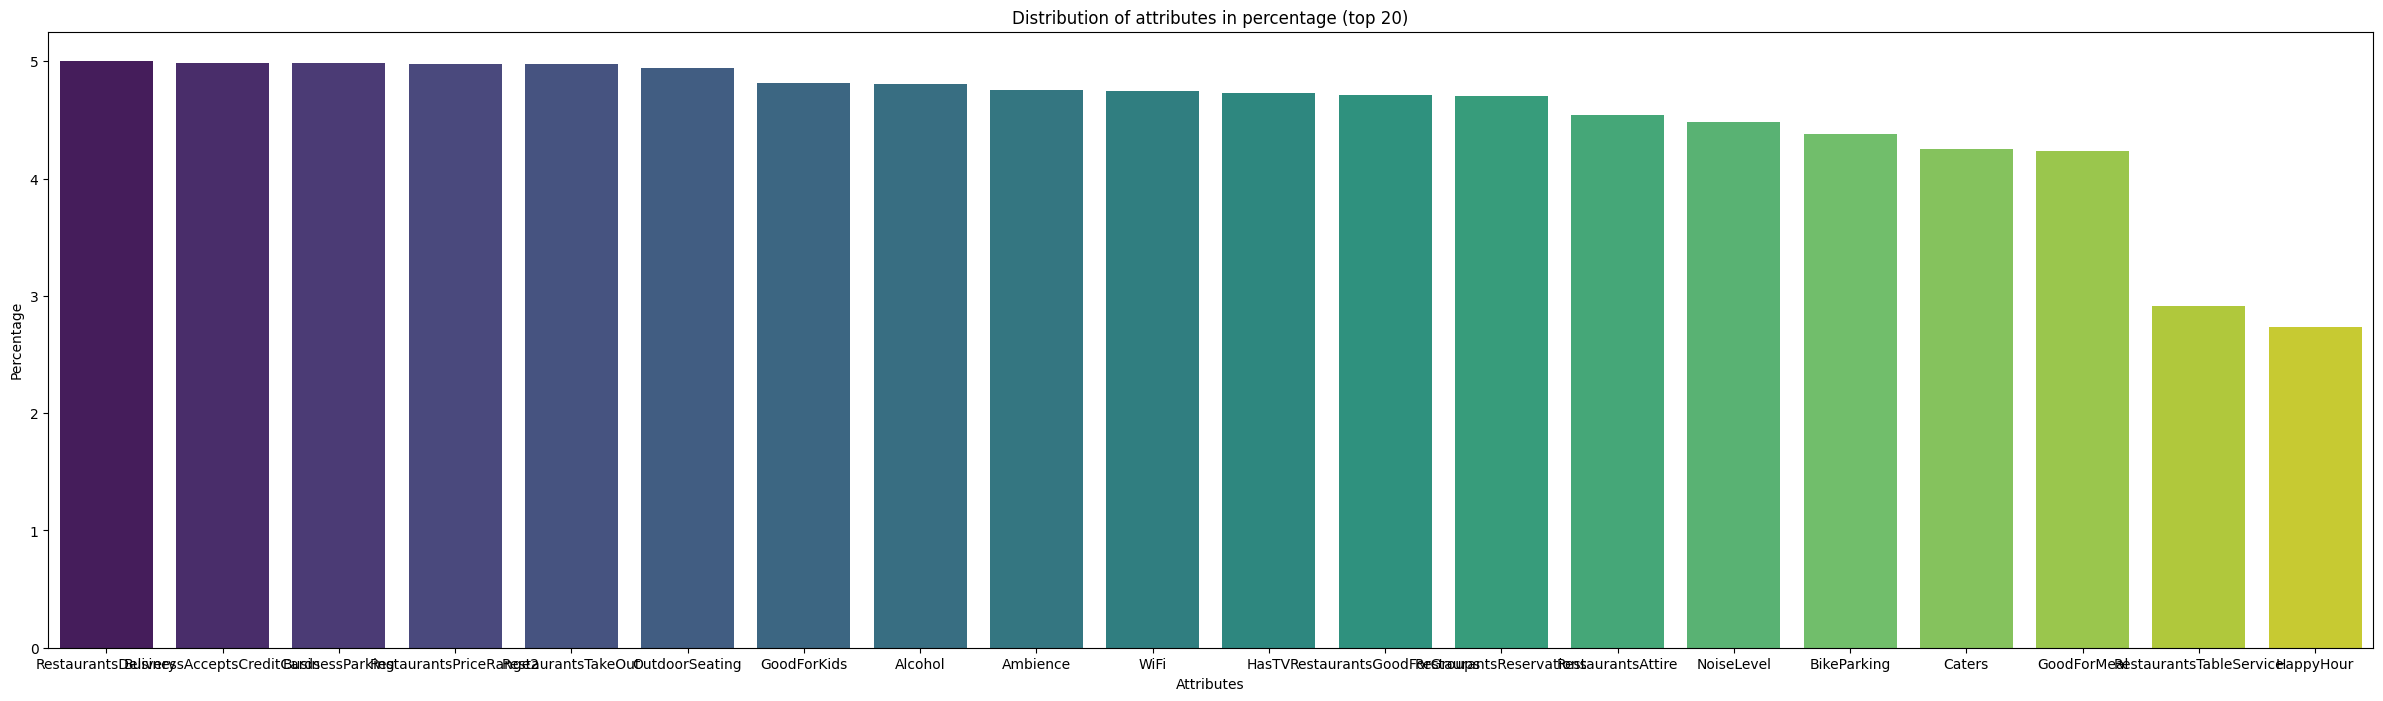

In [165]:
##################################################################
# AVERAING PER attribute

# Plot the results
mean_ratings = attribute_individ_df.groupby("attributes_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 8))
plt.title("Mean rating per attribute (top 20)")
sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Mean Rating")
plt.show()


##################################################################
# Calculate the percentage distribution
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot the results
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ["attributes", "percentage"]
plt.figure(figsize=(30, 8))
plt.title("Distribution of attributes in percentage (top 20)")
sns.barplot(x="attributes", y="percentage", data=attribute_percentages_df[:20], palette="viridis")
plt.xlabel("Attributes")
plt.ylabel("Percentage")
plt.show()

#### Average rating per attribute for reviews judged "useful" at least 2 times

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4027543043.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")


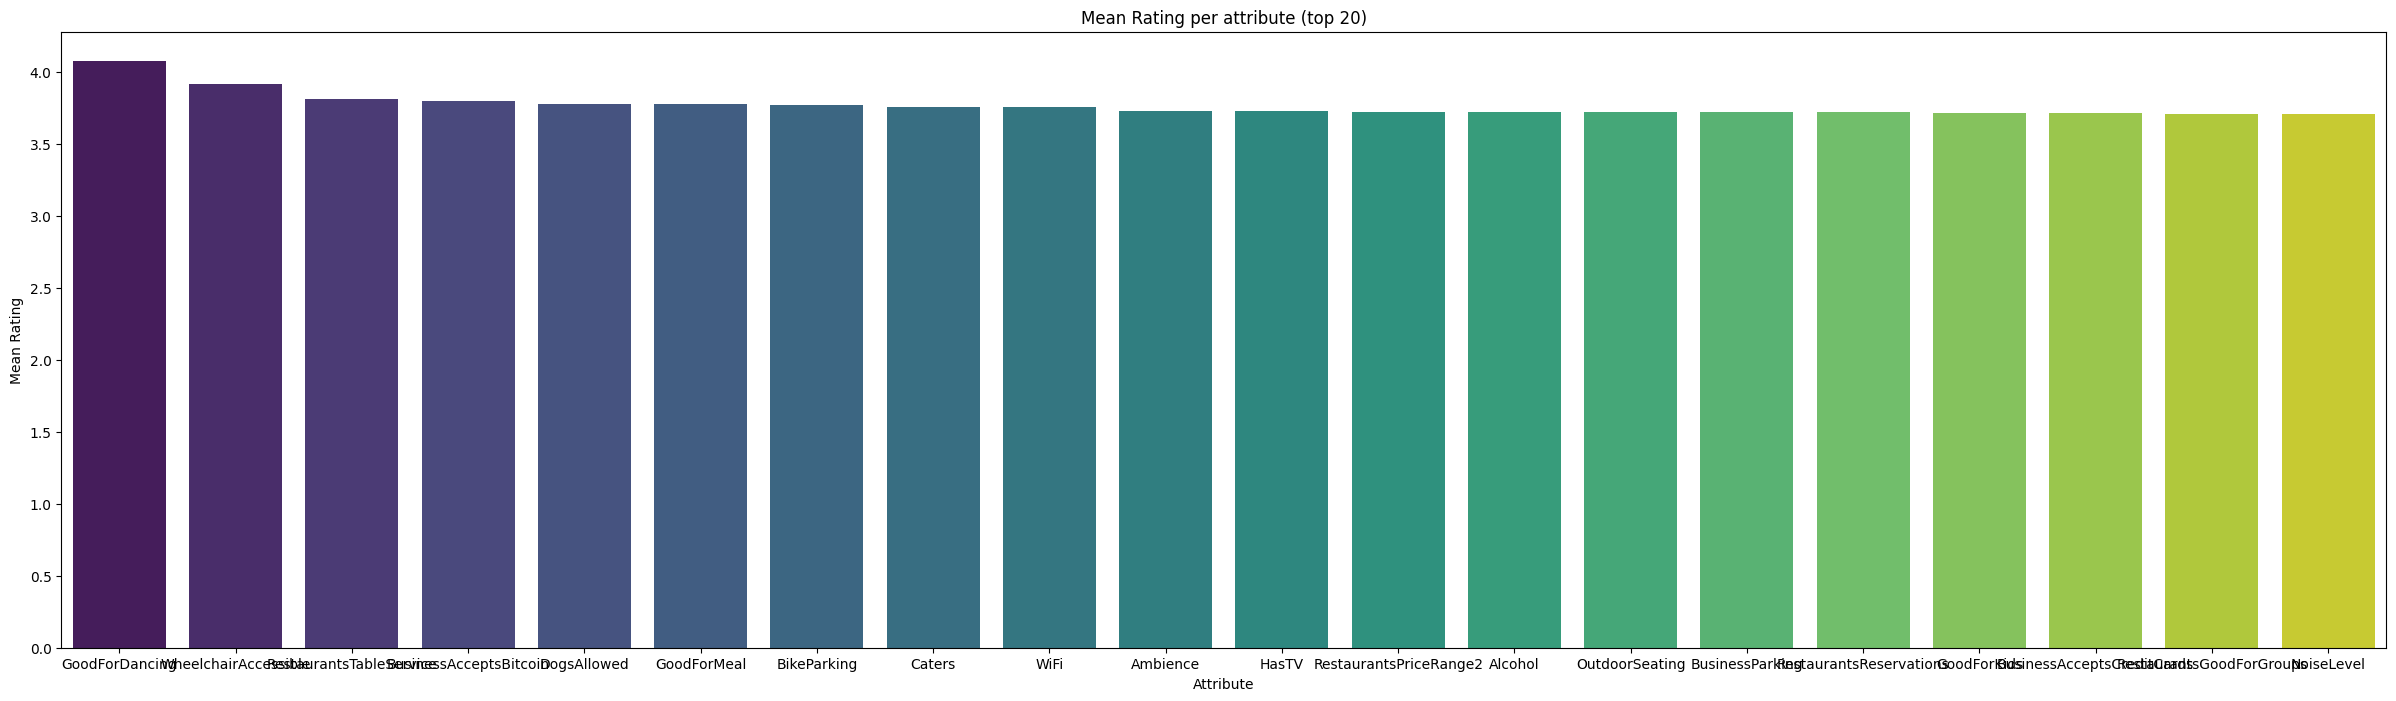

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4027543043.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attribute", y="percentage", data=attribute_percentages_df[:20], palette="viridis")


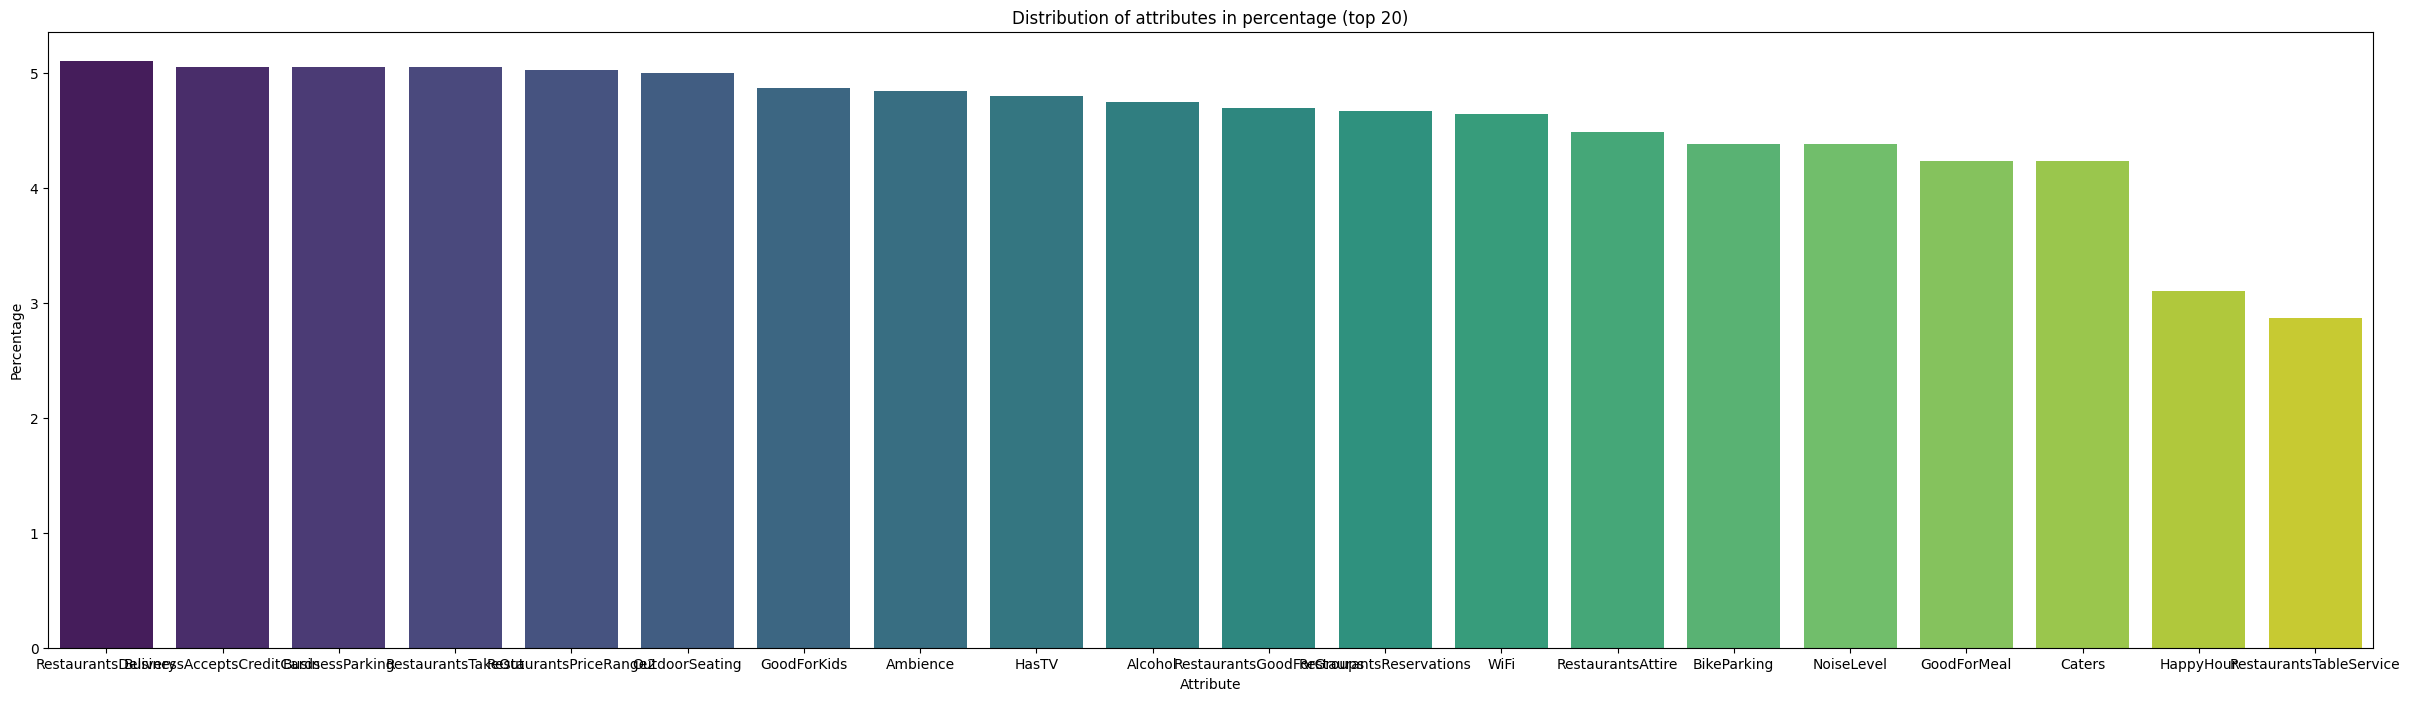

In [166]:
# Keep utility score >= 2
df_data_utility = attribute_individ_df[attribute_individ_df["useful"] >= 2]
attribute_counts = df_data_utility["attributes_list"].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot RATING
mean_ratings = df_data_utility.groupby("attributes_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 8))
plt.title("Mean Rating per attribute (top 20)")
sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Mean Rating")
plt.show()


# Plot FREQUENCY
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ["attribute", "percentage"]
plt.figure(figsize=(30, 8))
plt.title("Distribution of attributes in percentage (top 20)")
sns.barplot(x="attribute", y="percentage", data=attribute_percentages_df[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Percentage")
plt.show()

#### PLOT PER GROUP ATTRIBUTE

In [167]:
# Mean rating per category
mean_ratings["group_attribute"] = mean_ratings["attributes_list"].map(Attribute_groups)
mean_ratings = mean_ratings.groupby(["group_attribute", "attributes_list"])["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by=["group_attribute", "rating"], ascending=False)
mean_ratings.head(10)

,group_attribute,attributes_list,rating
26,Service Style,RestaurantsTableService,3.812500
23,Service Style,HasTV,3.727273
22,Service Style,BusinessAcceptsCreditCards,3.715736
24,Service Style,NoiseLevel,3.707602
25,Service Style,RestaurantsDelivery,3.698492
27,Service Style,RestaurantsTakeOut,3.690355
21,Pricing,RestaurantsPriceRange2,3.724490
20,Meal Times,GoodForMeal,3.775758
19,Location,OutdoorSeating,3.723077
17,Location,BusinessParking,3.720812


C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


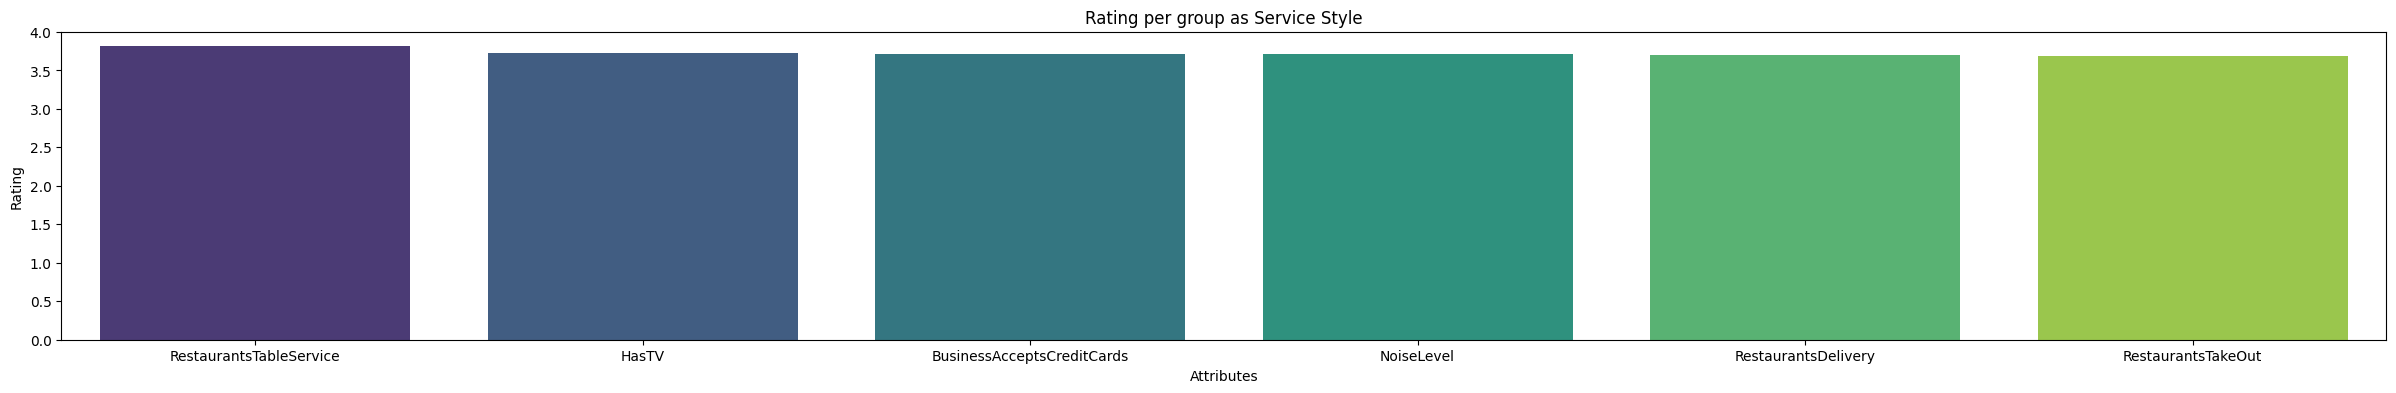

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


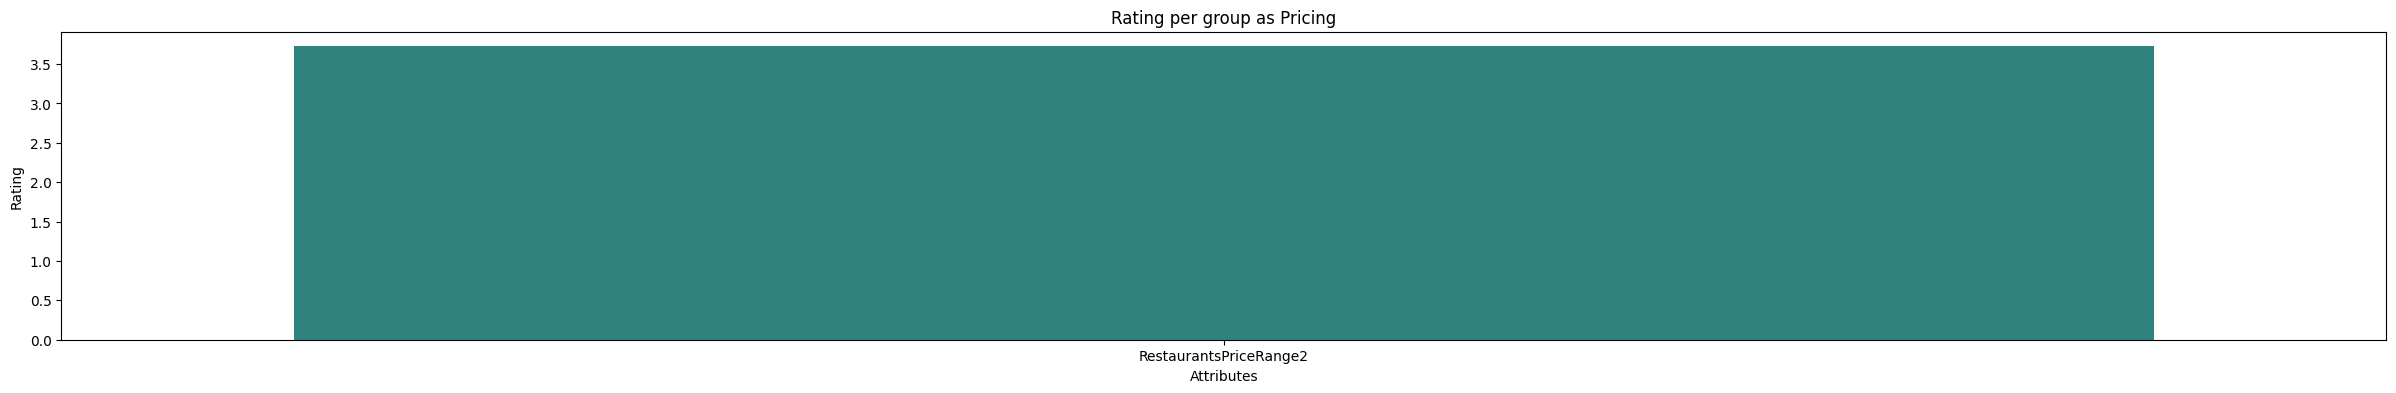

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


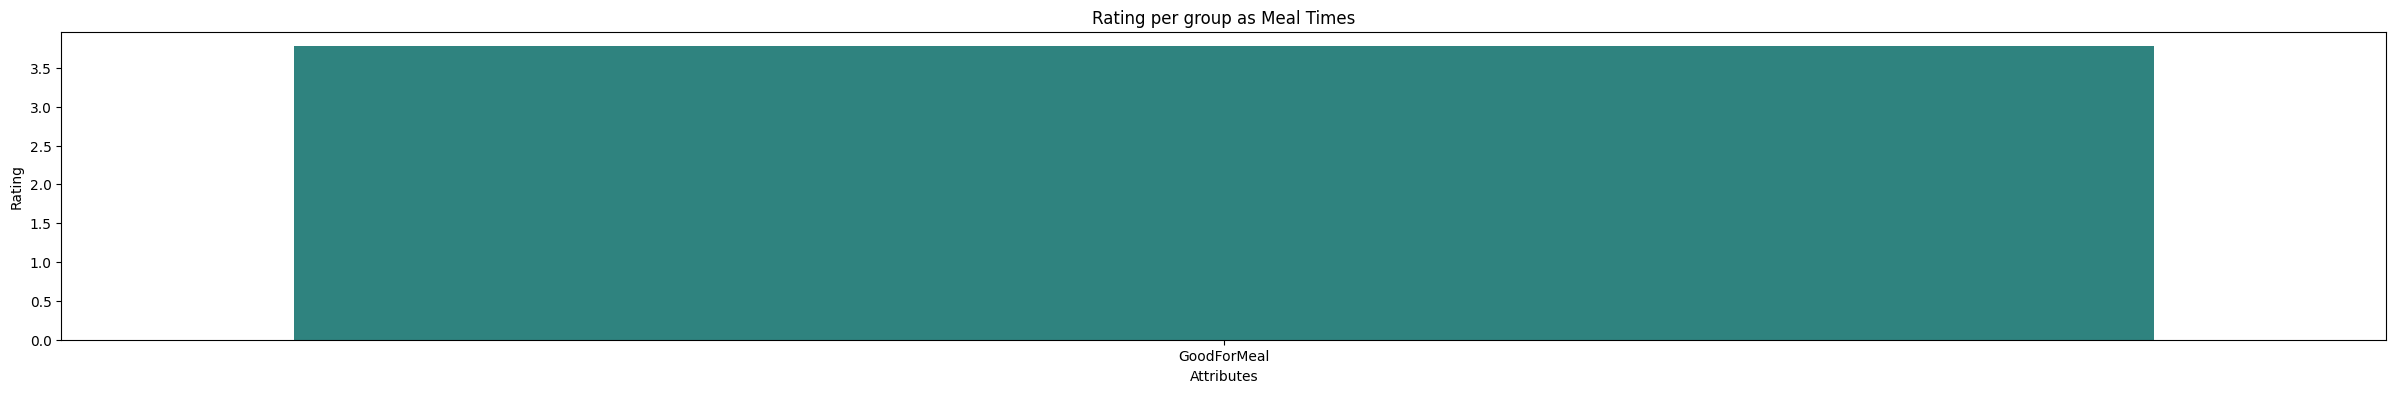

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


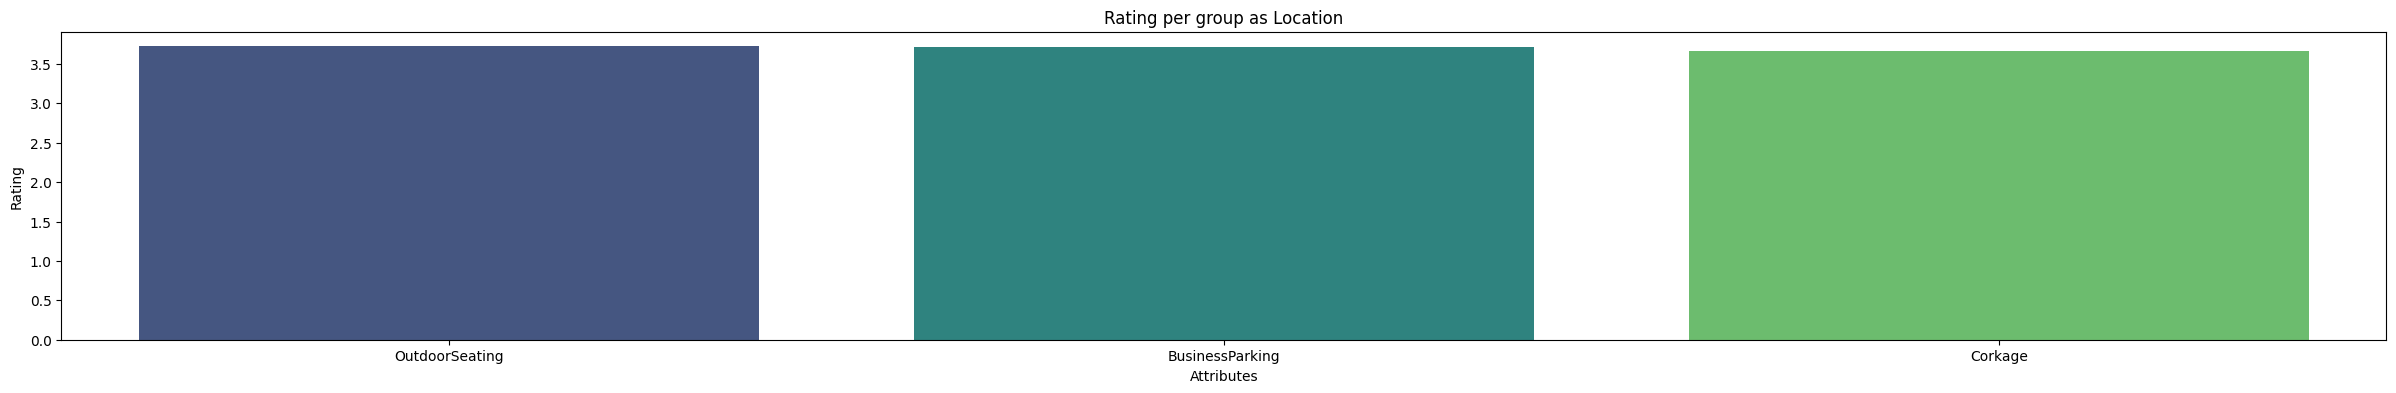

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


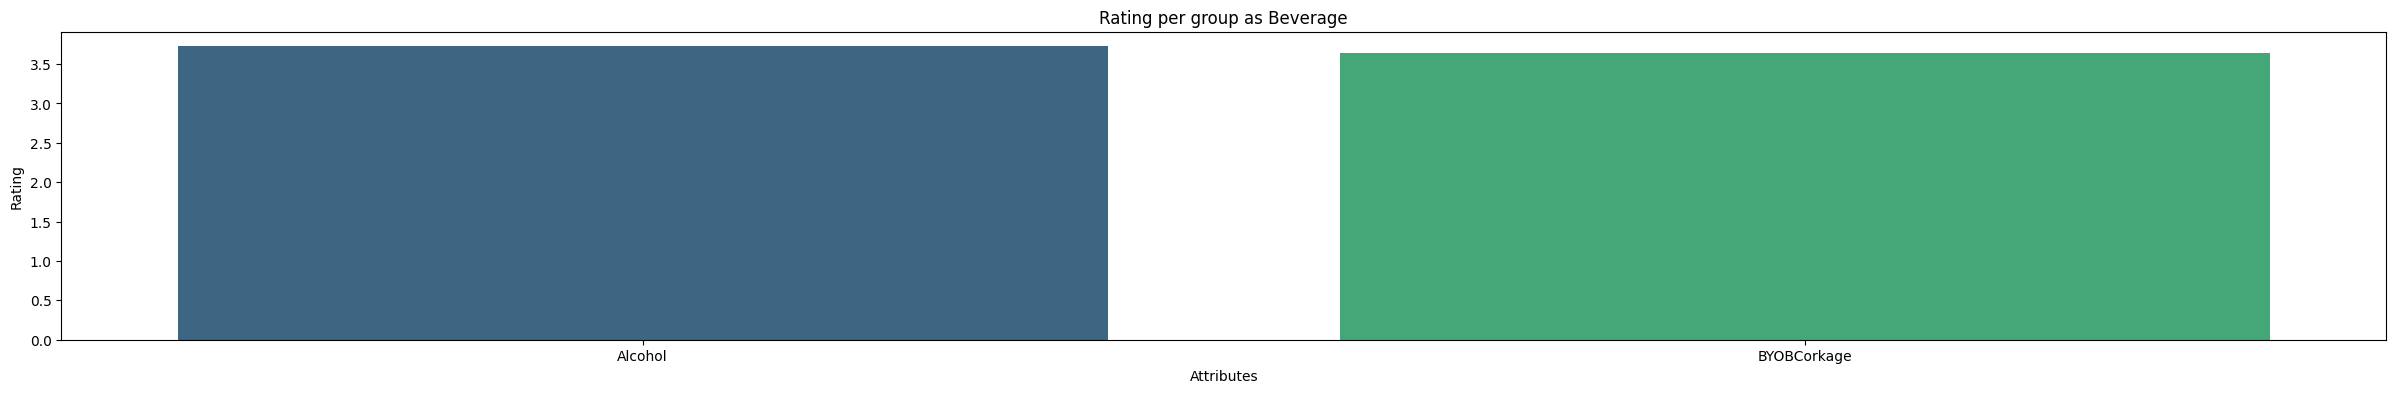

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


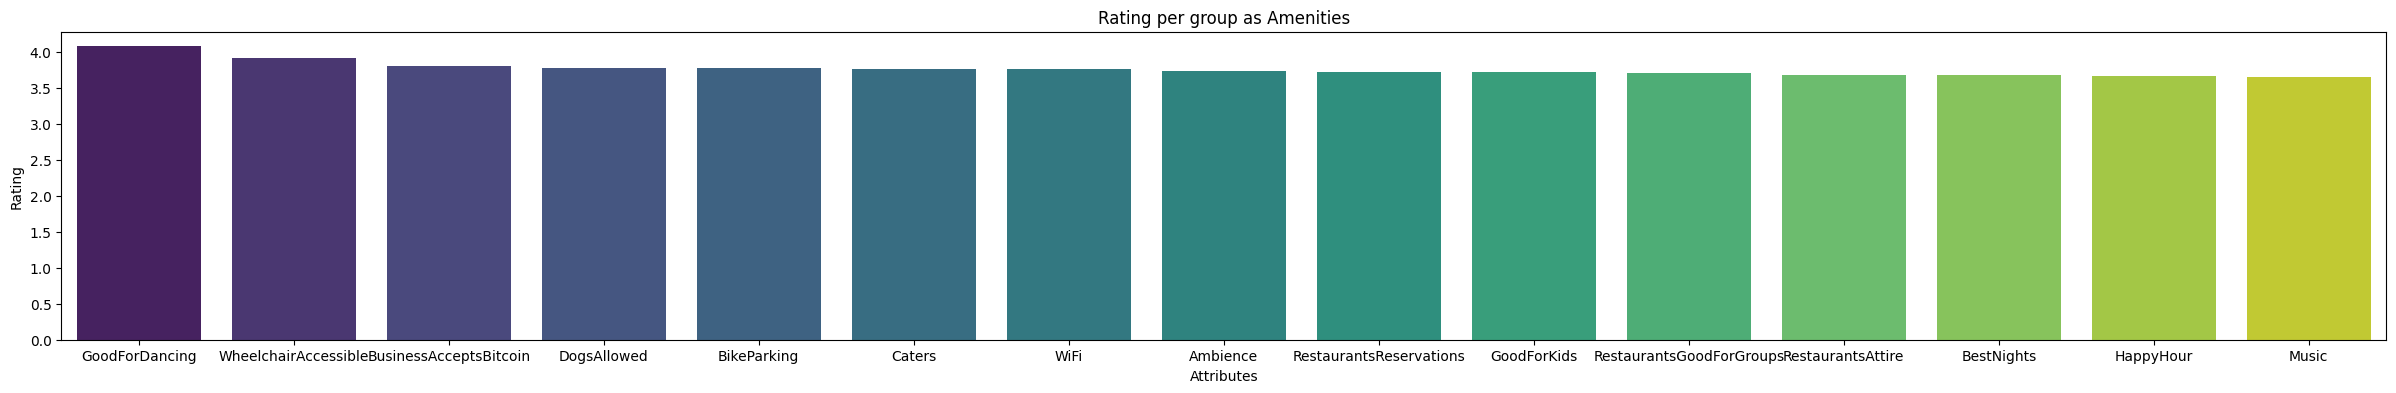

In [168]:
# Barplots per attribute
for group in mean_ratings["group_attribute"].unique():
    df_filt = mean_ratings[mean_ratings["group_attribute"] == group]
    df_filt[["attributes_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Rating per group as {group}")
    sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Rating")
    plt.show()

Having filtered the reviews per usefulness we observe.... TO COMPLETE

## Insights based on sentiments

In the following section we will compute a ranking based on a score obtained by considering the mean of a sentiment analysis of reviews. When a review is judged "POSITIVE" the reviews gets value 1, else 0. Then, an average per category or attribute respectively is computed. The factors are then ranked according to the score obtained. Only the first (up to 20) elements are displayed.

#### Compute the sentiment analysis score per category.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3156346273.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("POSITIVE", 1)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3156346273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


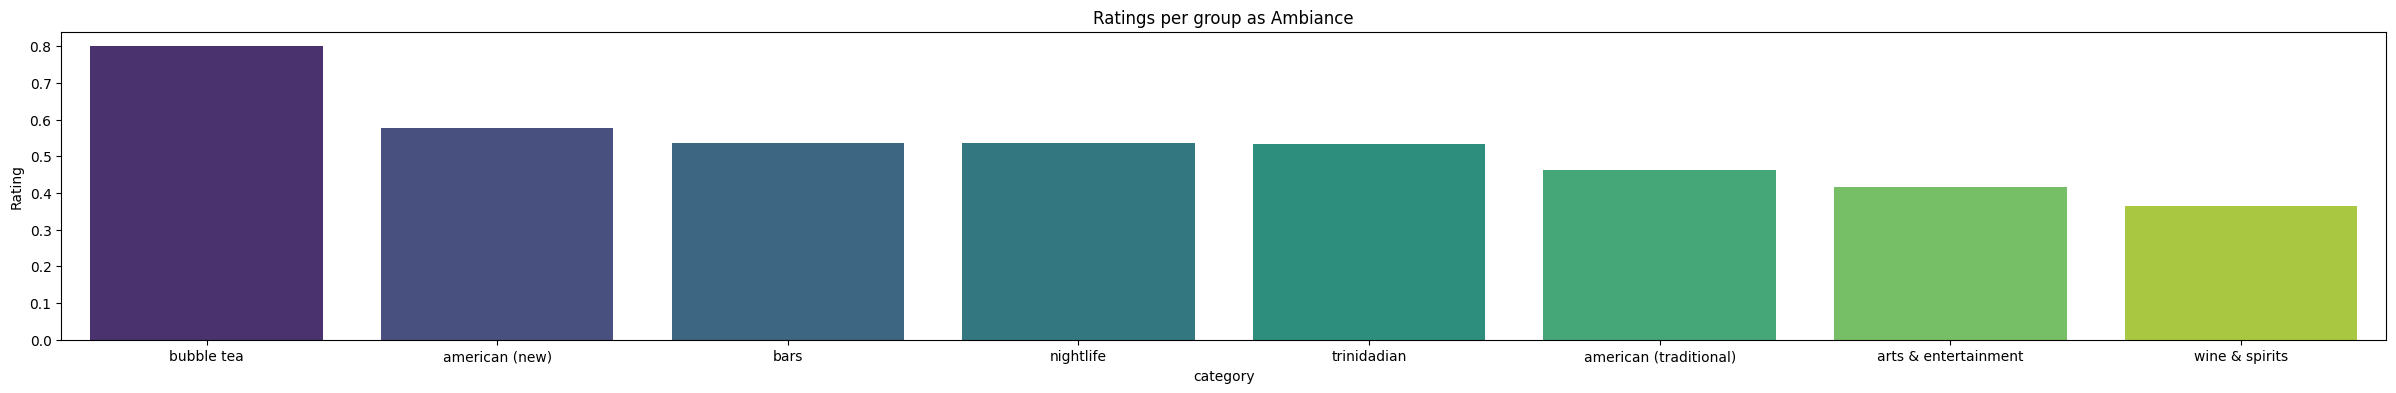

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3156346273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


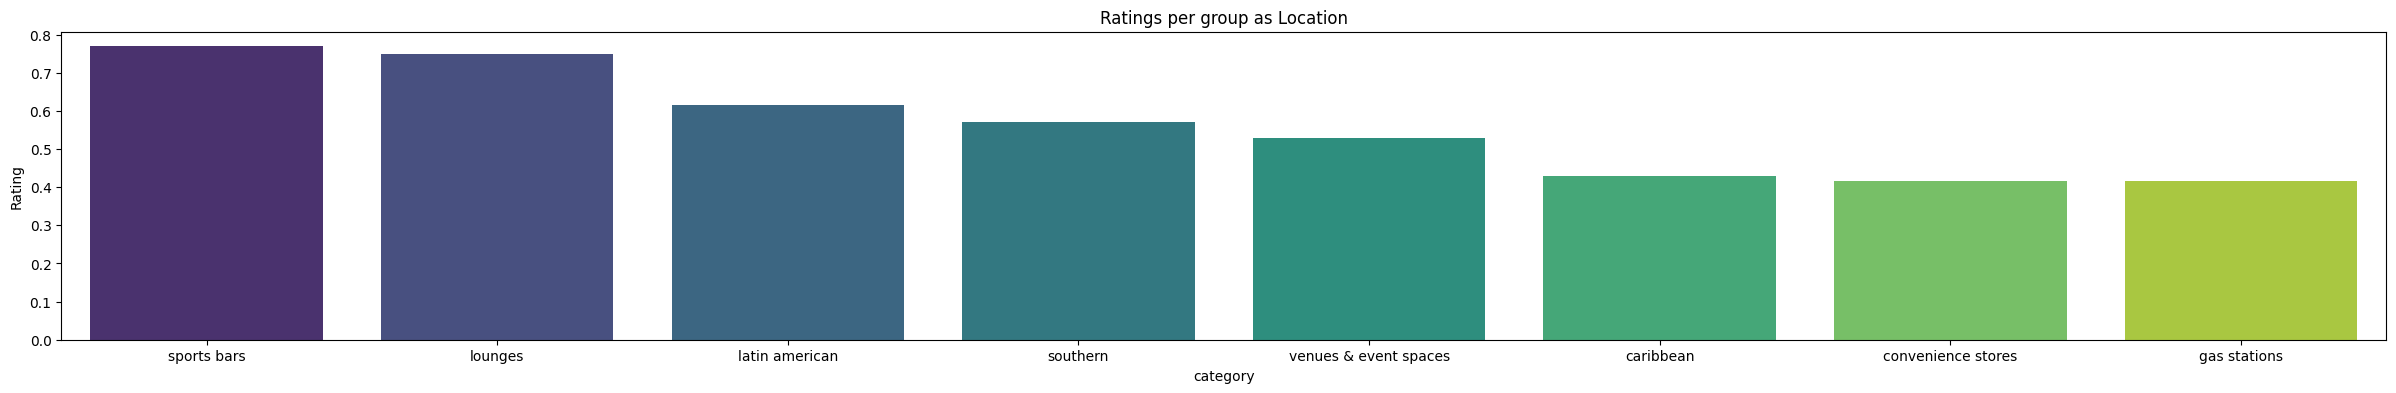

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3156346273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


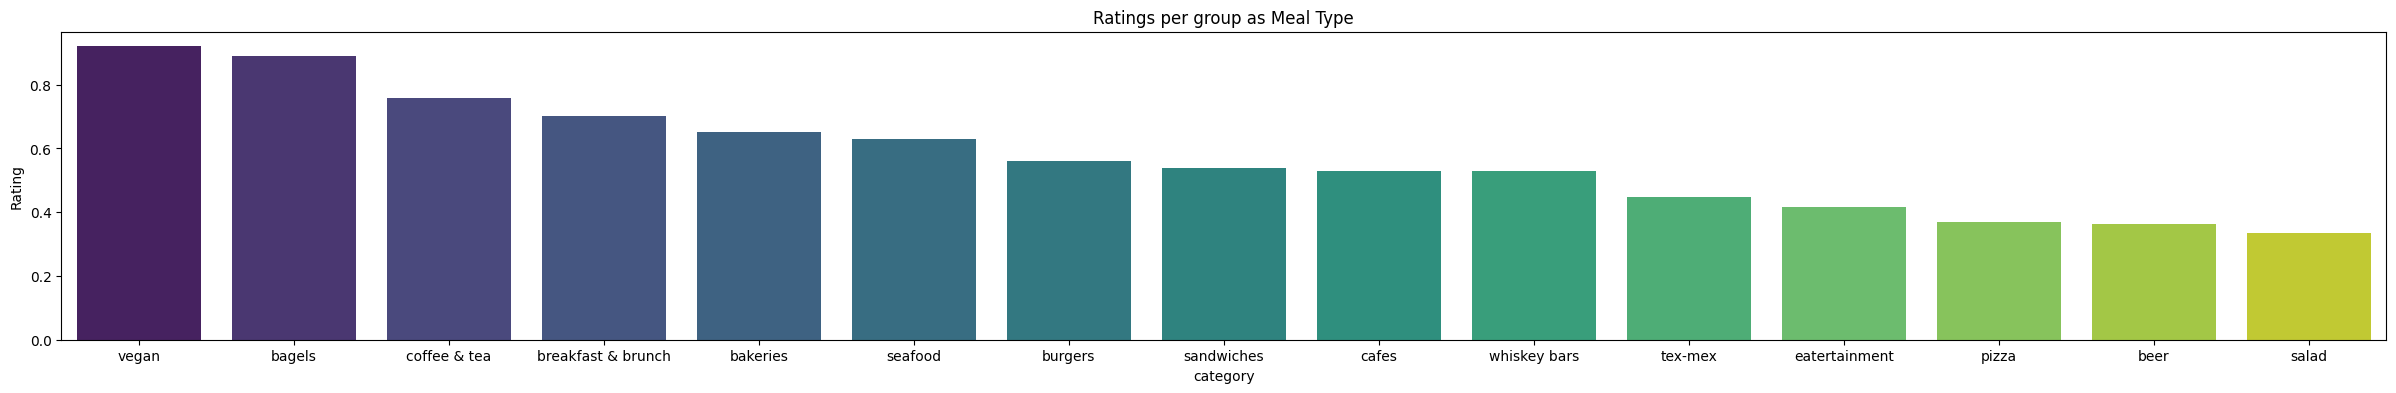

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3156346273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


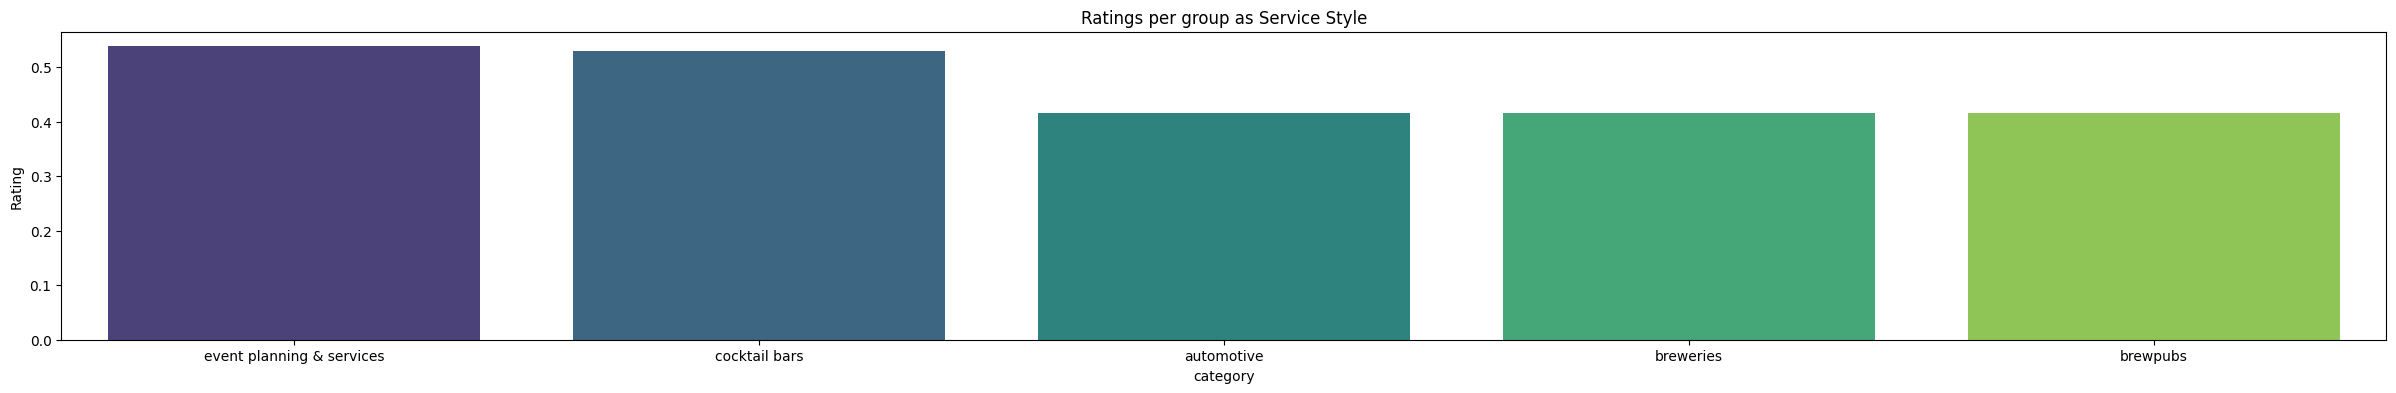

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3156346273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


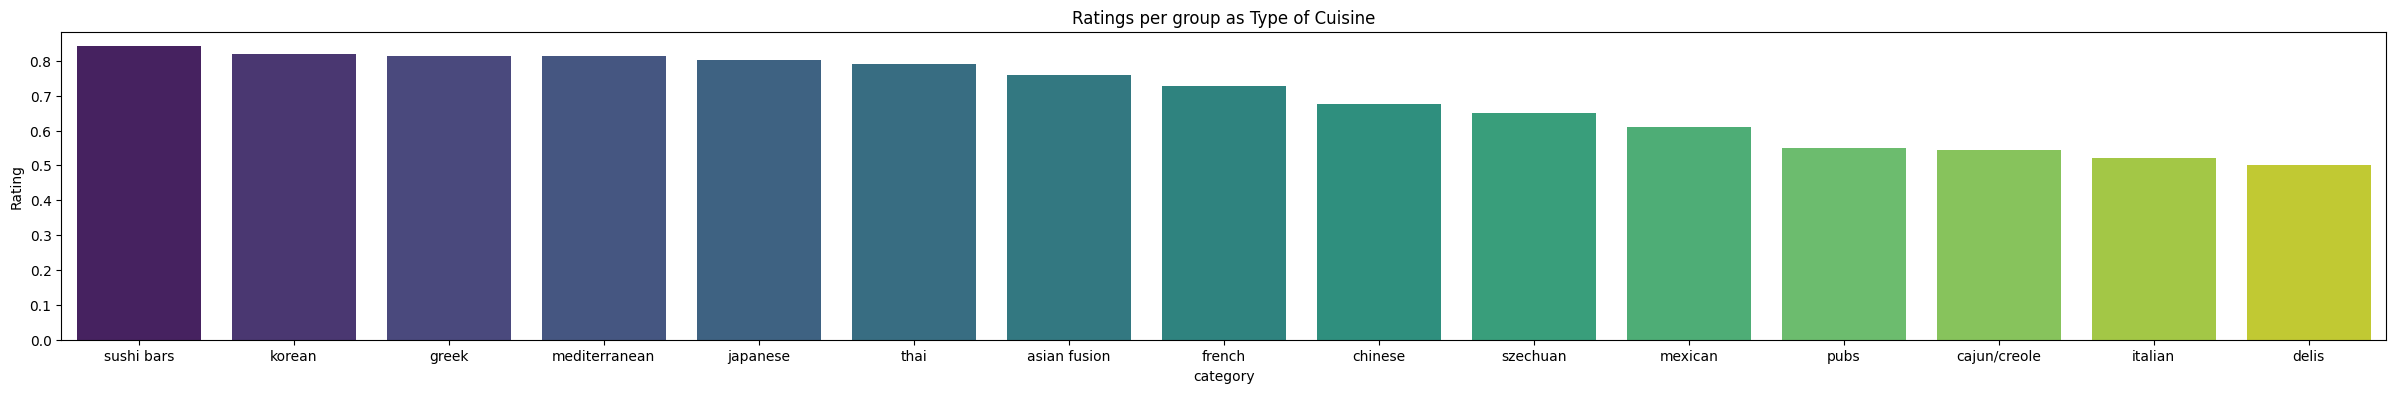

In [169]:
# Compute a mean per category
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("NEGATIVE", 0)
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("POSITIVE", 1)
mean_sent_category = categories_individ_df.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)

# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Ratings per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("category")
    plt.ylabel("Rating")
    plt.show()

#### Compute sentiment analysis per category considering the weights given by "useful" dimension.

We explore a potential improvement in the ranking of factors by assigning more weights to reviews according to dimension "useful". Therefore, we rely on the judgment of the crowd to give reviews a special treatment. This is done by simply replicating values according to the number in the column "useful". For example, if review n°1 has a value of 3 in "useful", we replicate it 3 times.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2974875011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


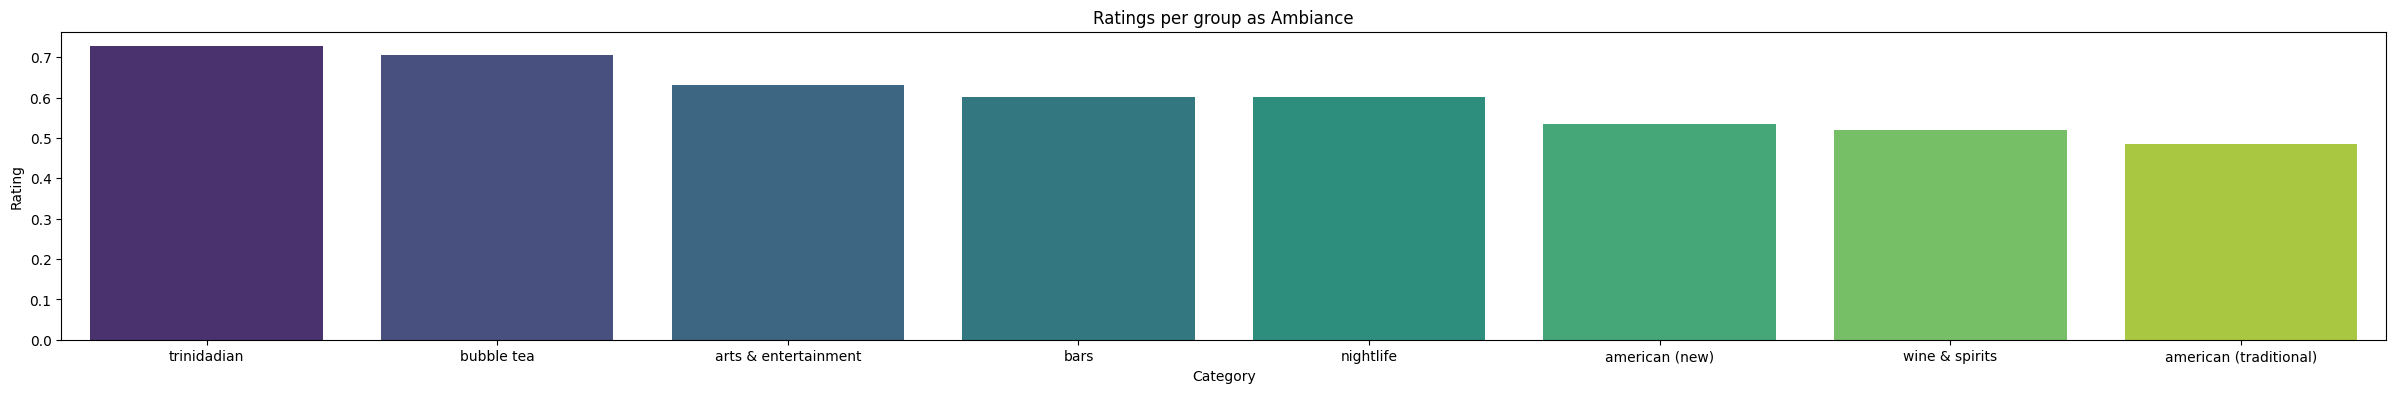

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2974875011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


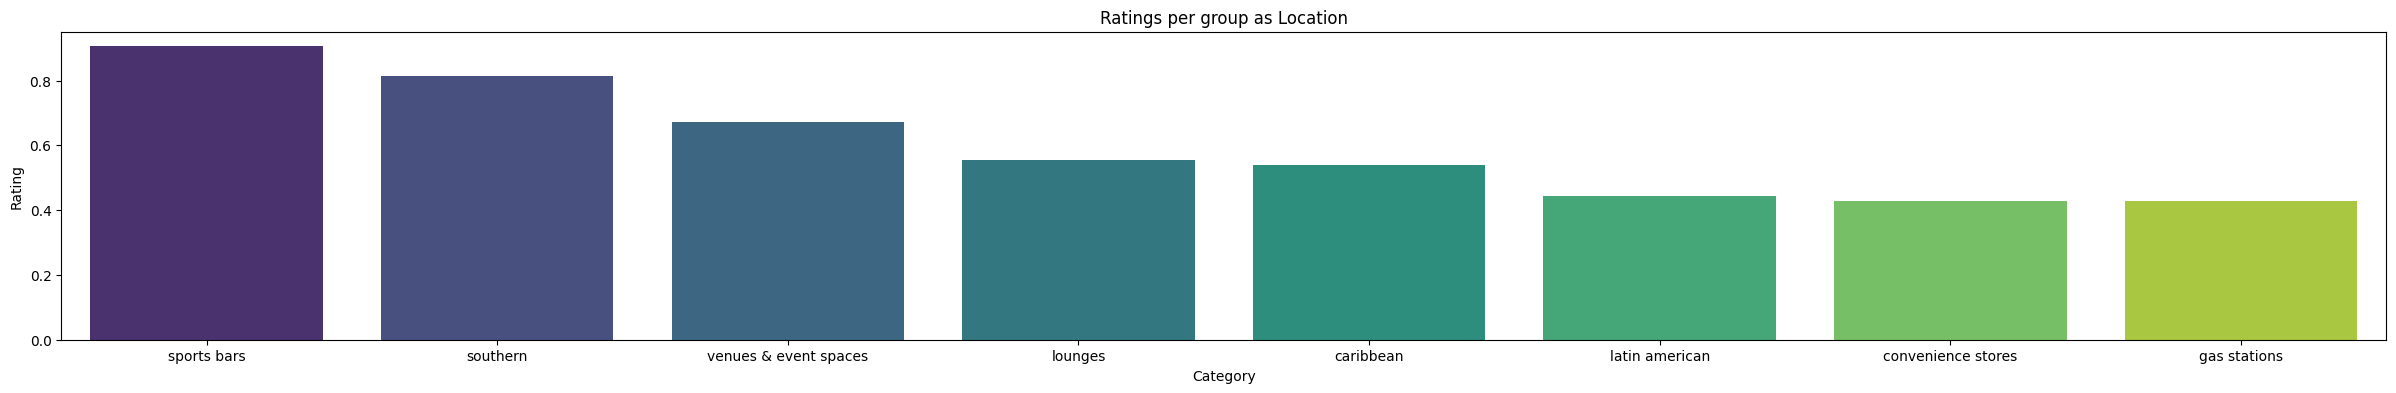

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2974875011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


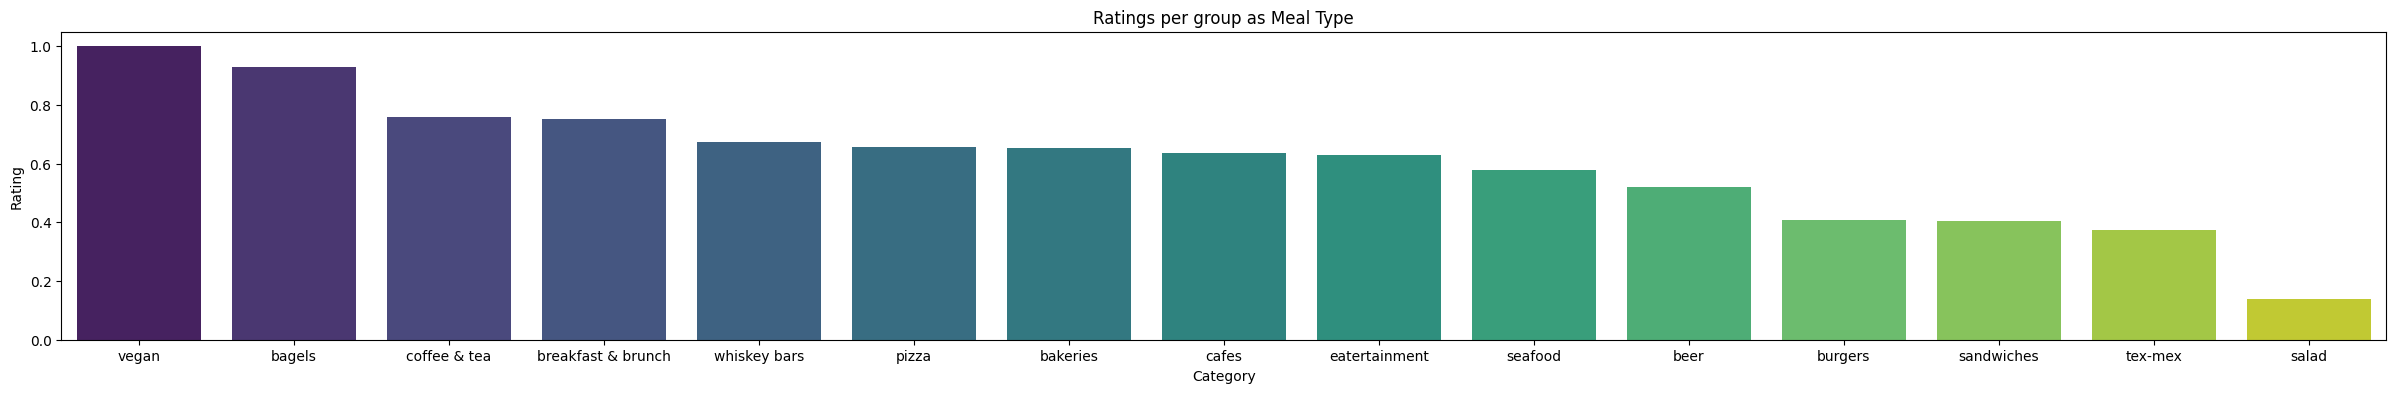

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2974875011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


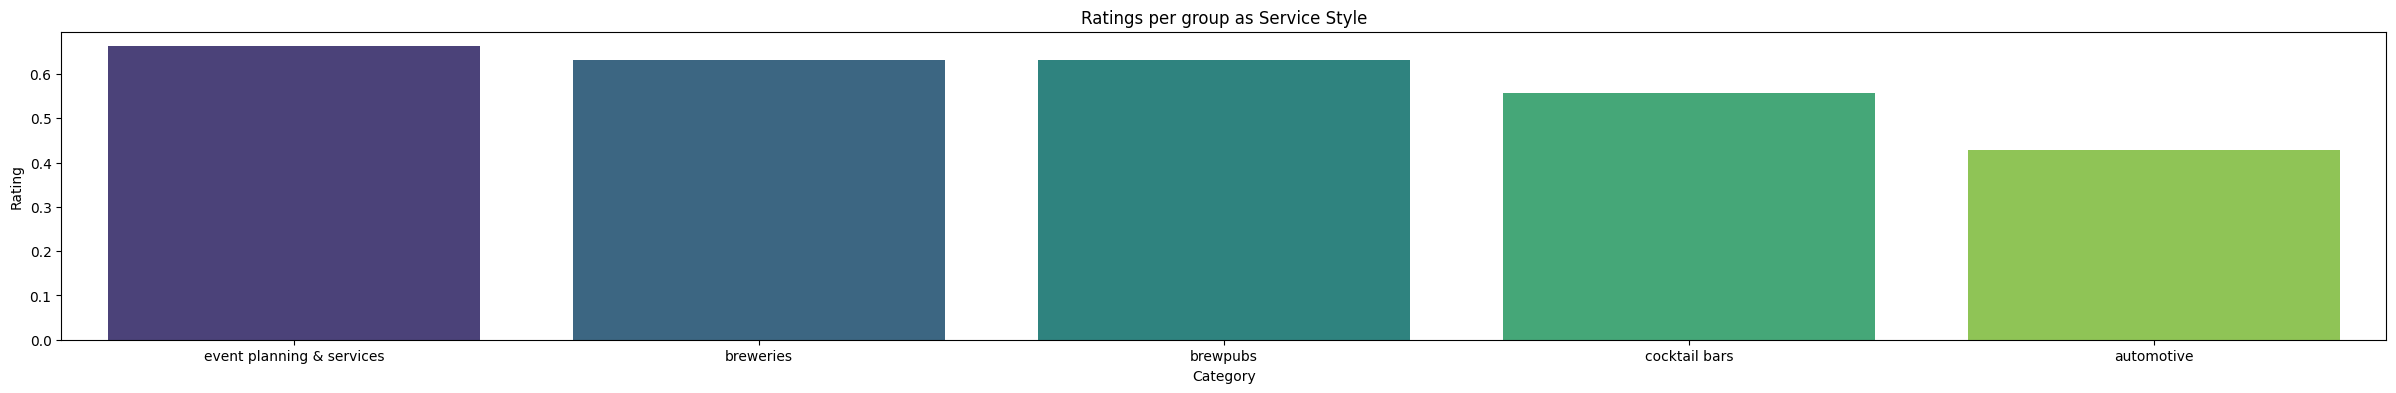

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2974875011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


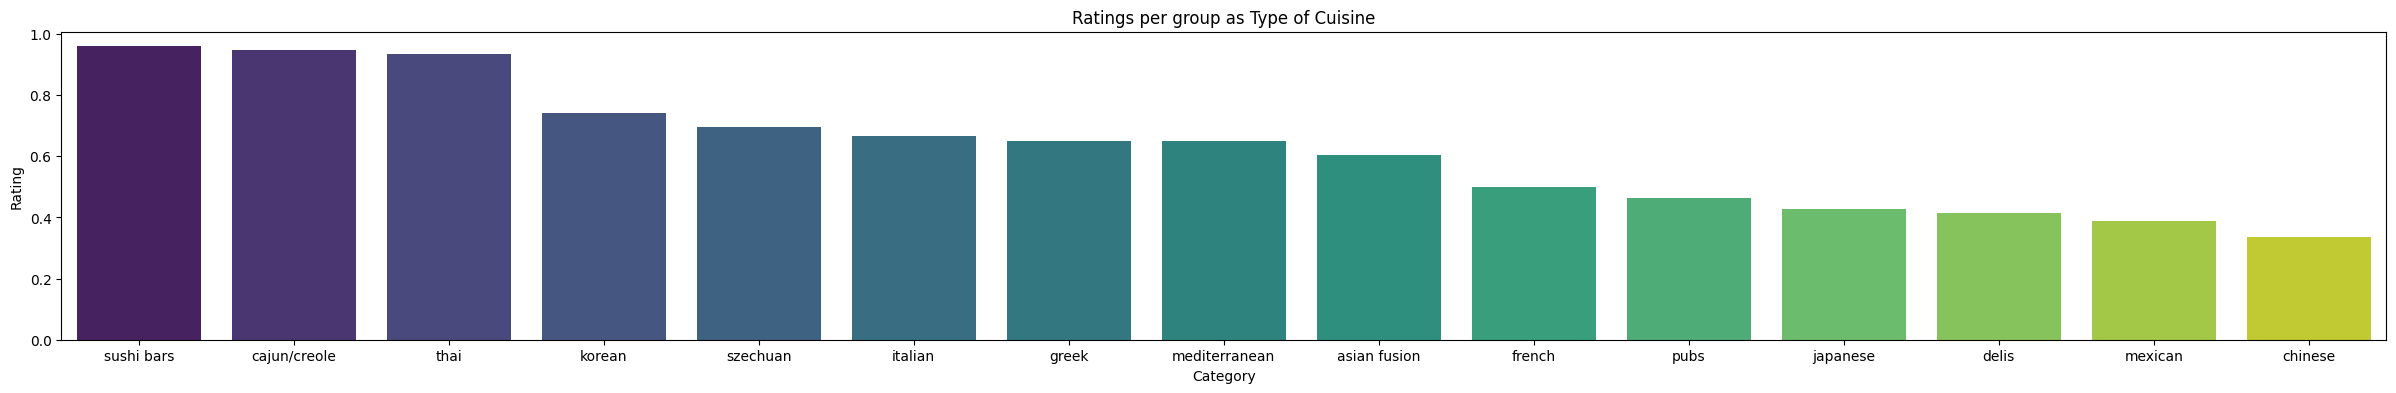

In [170]:
# Extend dataframe by replicating obbservation according to "useful" value
df_useful_category = categories_individ_df.loc[np.repeat(categories_individ_df.index, categories_individ_df["useful"])].reset_index(drop=True)

# Compute a mean per category
mean_sent_category = df_useful_category.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)


# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Ratings per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Rating")
    plt.show()

#### Compute sentiment analysis per attribute considering the weights given by "useful" dimension.

We replicate the experience, but for attributes.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("POSITIVE", 1)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


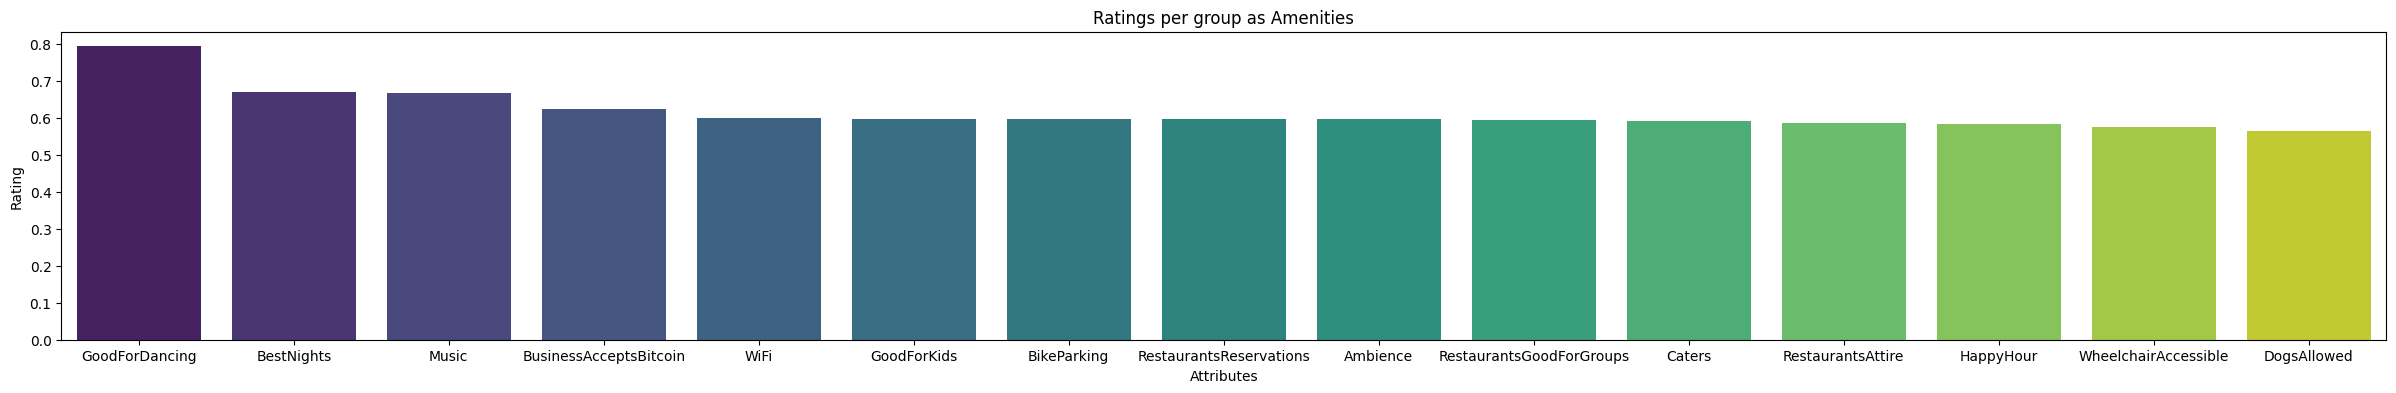

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


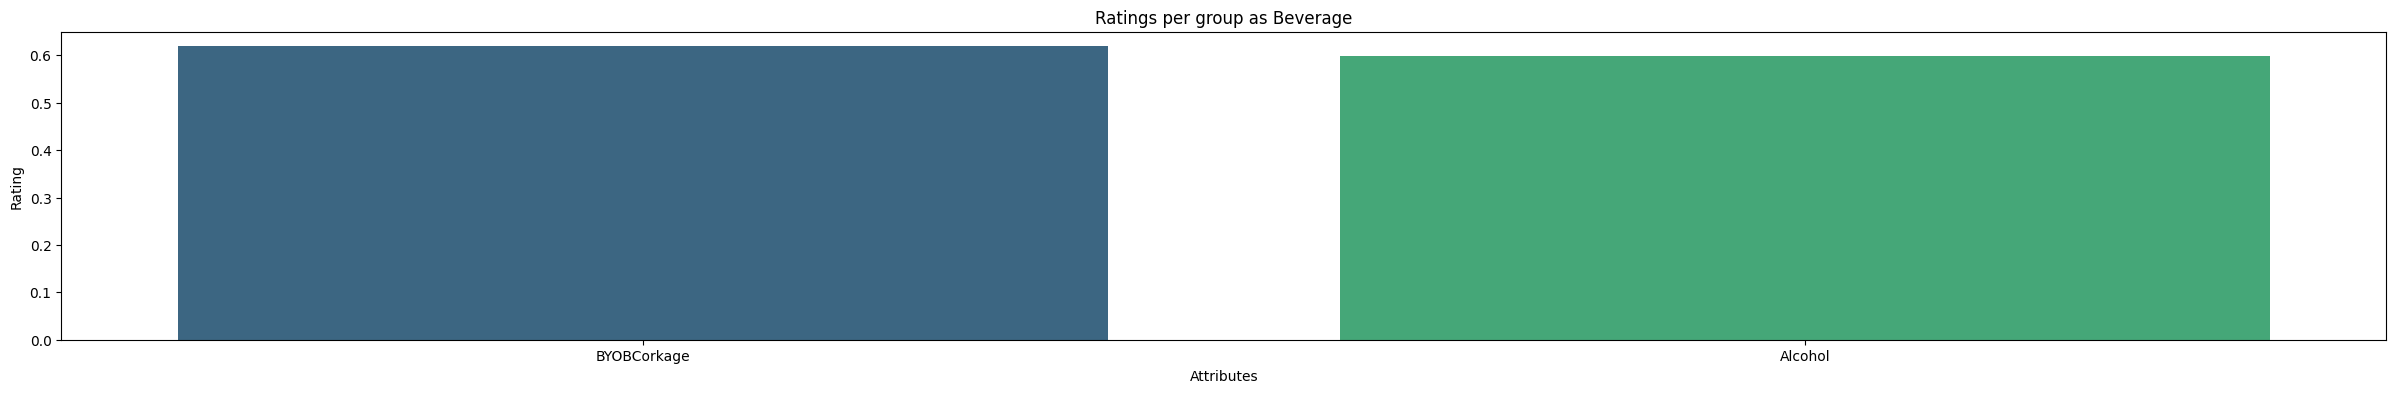

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


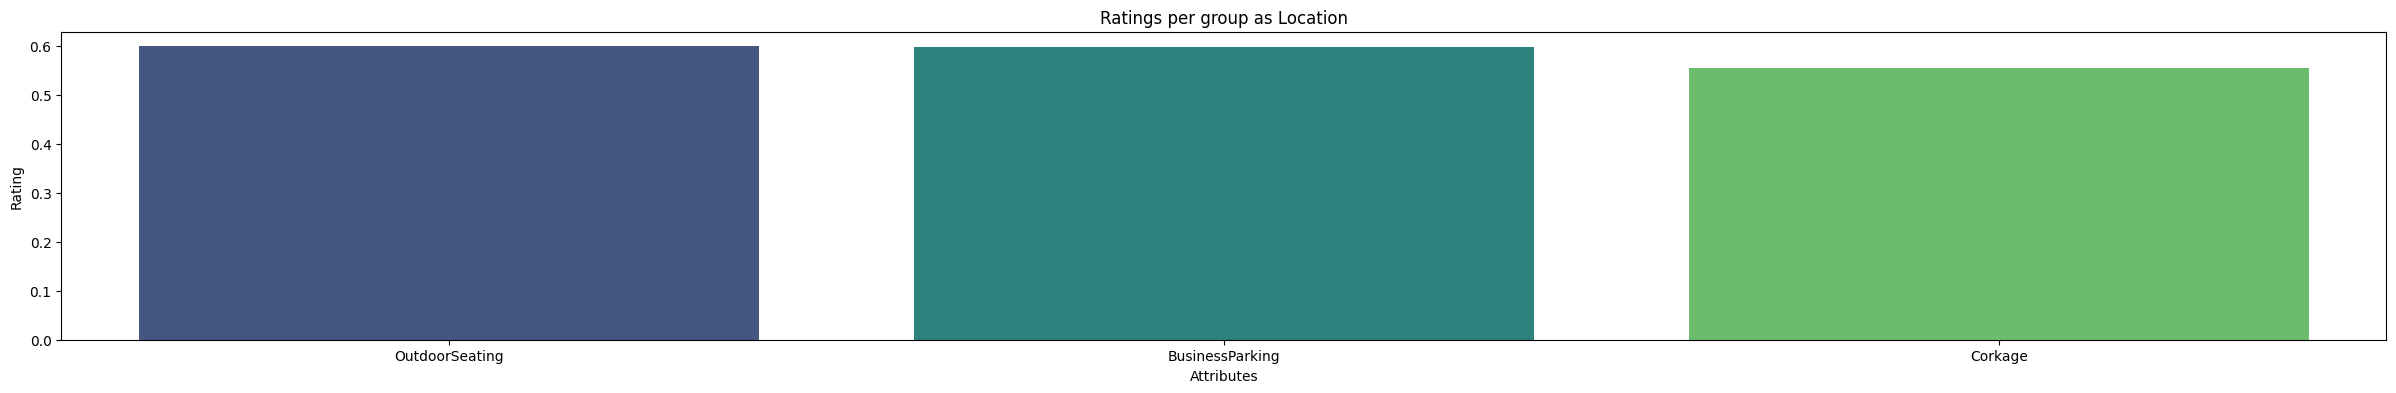

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


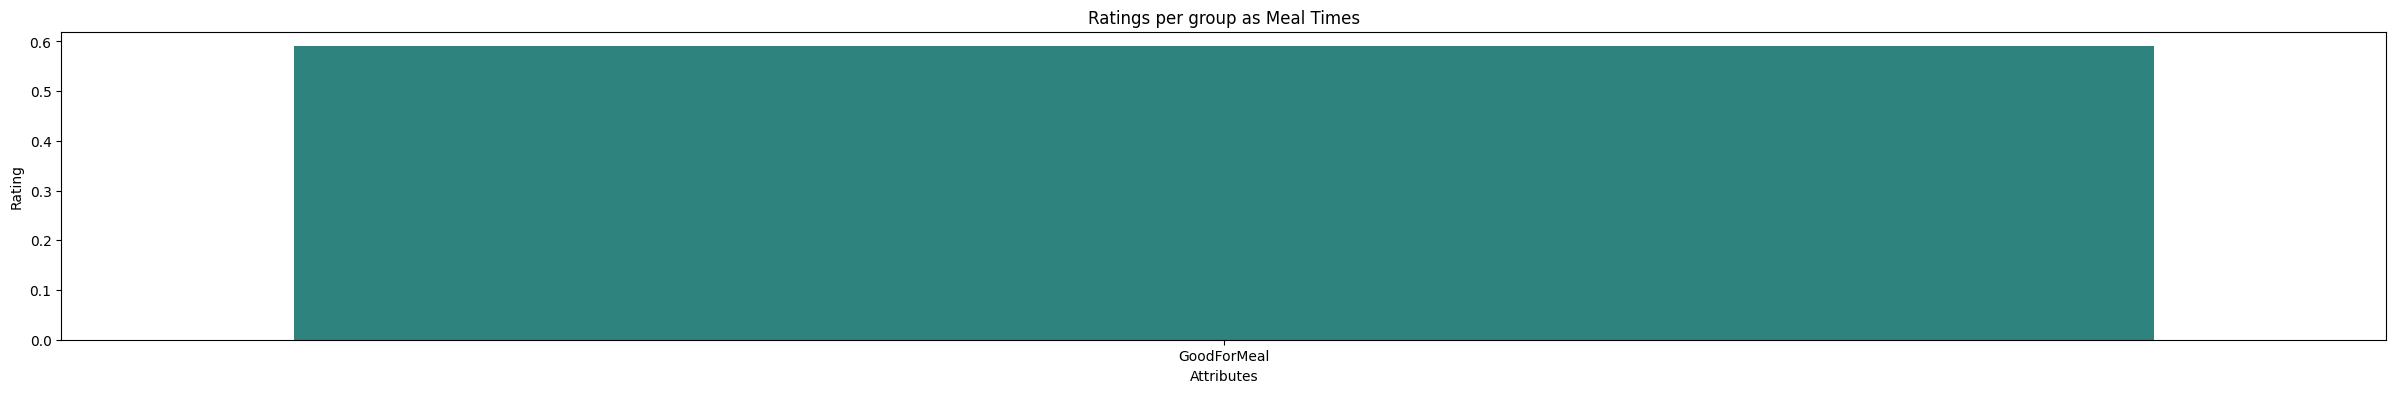

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


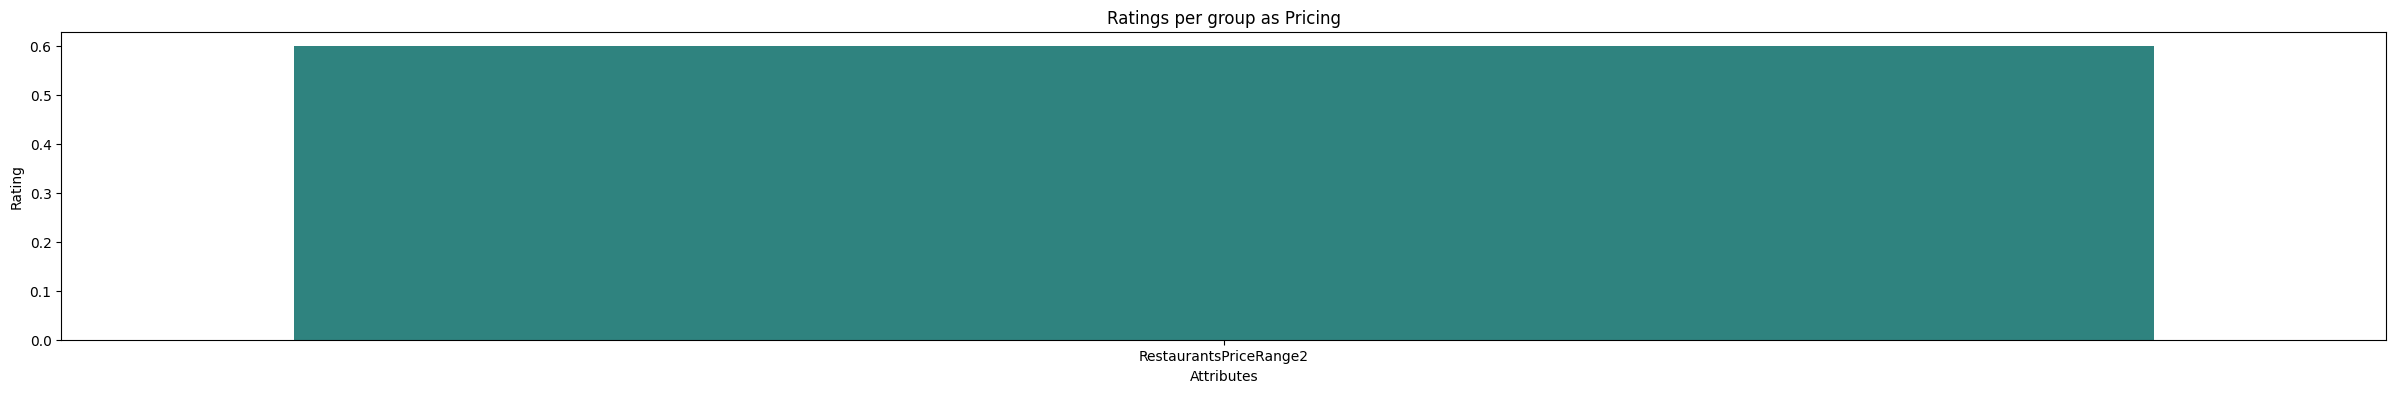

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2339467691.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


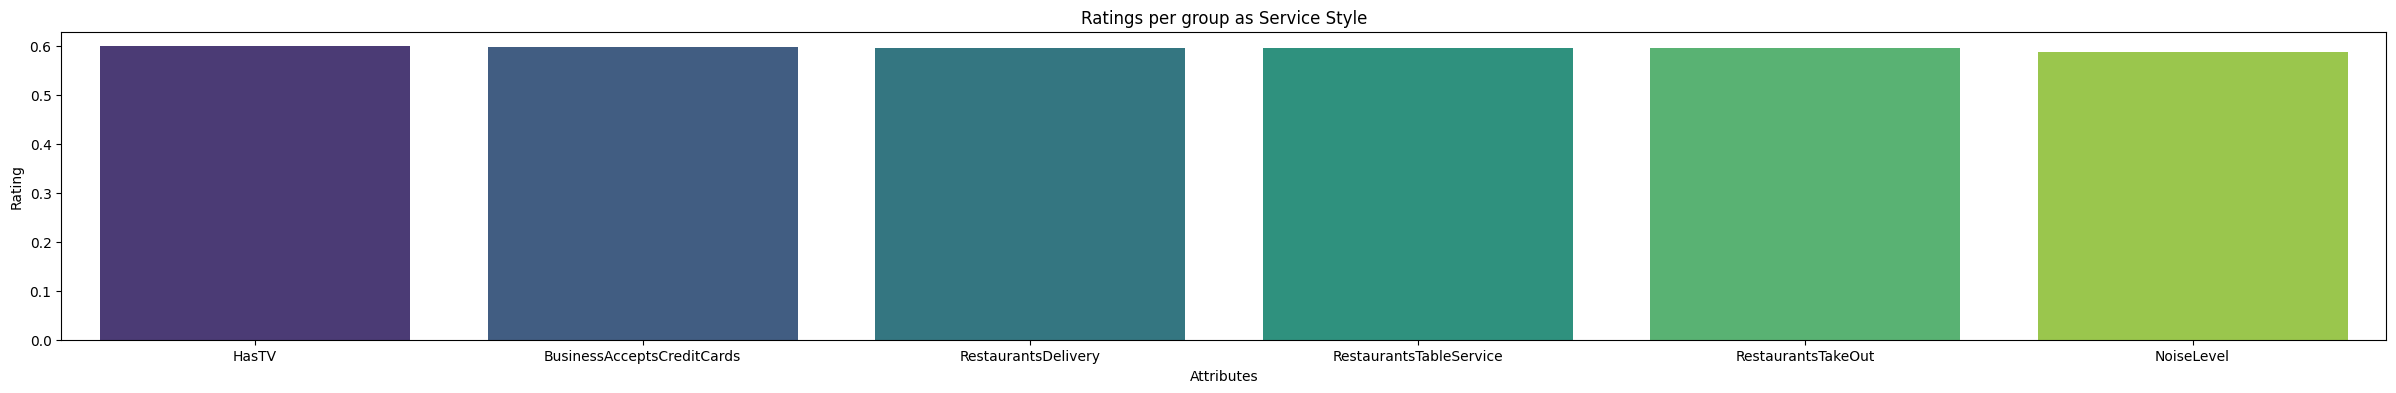

In [171]:
# Compute a mean per attribute
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("NEGATIVE", 0)
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("POSITIVE", 1)

df_useful_attribute = attribute_individ_df.loc[np.repeat(attribute_individ_df.index, attribute_individ_df["useful"])].reset_index(drop=True)

mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["sentiment"].mean().reset_index()
mean_sent_attribute.sort_values(by="sentiment", ascending=False)
mean_sent_attribute

# Barplots per category and sentiment
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Ratings per group as {group}")
    sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Rating")
    plt.show()

In order to extract the maximum amount of information from our data set, we wanted to take advantage of the "useful" variable. Thus, our hypothesis is that a person who gives a "useful" vote finds the respective review relevant. It means that either the person has not visited the restaurant yet and she has learned something useful, or she has visited it and she share the opinion in the review. As such, it is a quality metric that we would like to use to hilight insights.

In the analysis above, we sought to explore insights in the datasets targeted at Philadelphia using NLP methods and statistical calculations. Our approach is based on a quantitative and qualitative view of reviews linked to "attributes" and "categories" by business. This gives us an appreciative idea of the importance of different ratings. As the problem seeks to discover what is liked by consumers, we refined our analysis to consider only reviews classified as positive. We continued by groupping the categories and attributes by factors (groups) to get a more precise view of similar variables in our analysis. 

Next, we ...

## Qualitative customer reviews only

We go deeper in the exploration by considering customer quality only this time. We will filter the reviews to keep only those provided by ustomers having a profile with at least 1 useful review and at least 1 fan. This filter reduces the total number of reviews of almost 50%.

In [172]:
# Filter the df dataset based on quality of users
df_users = pd.read_csv("data/ATML2024_users.csv", header=0)
df_users = df_users[["user_id", "useful", "fans"]]
df_users = df_users[(df_users["useful"] >= 1) & (df_users["fans"] >= 1)]
df_UserQuality_atr = attribute_individ_df[attribute_individ_df["user_id"].isin(df_users["user_id"].unique())]
df_UserQuality_cat = categories_individ_df[categories_individ_df["user_id"].isin(df_users["user_id"].unique())]

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("NEGATIVE", 0)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("POSITIVE", 1)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:20: FutureWarning: 

Passing `palette` witho

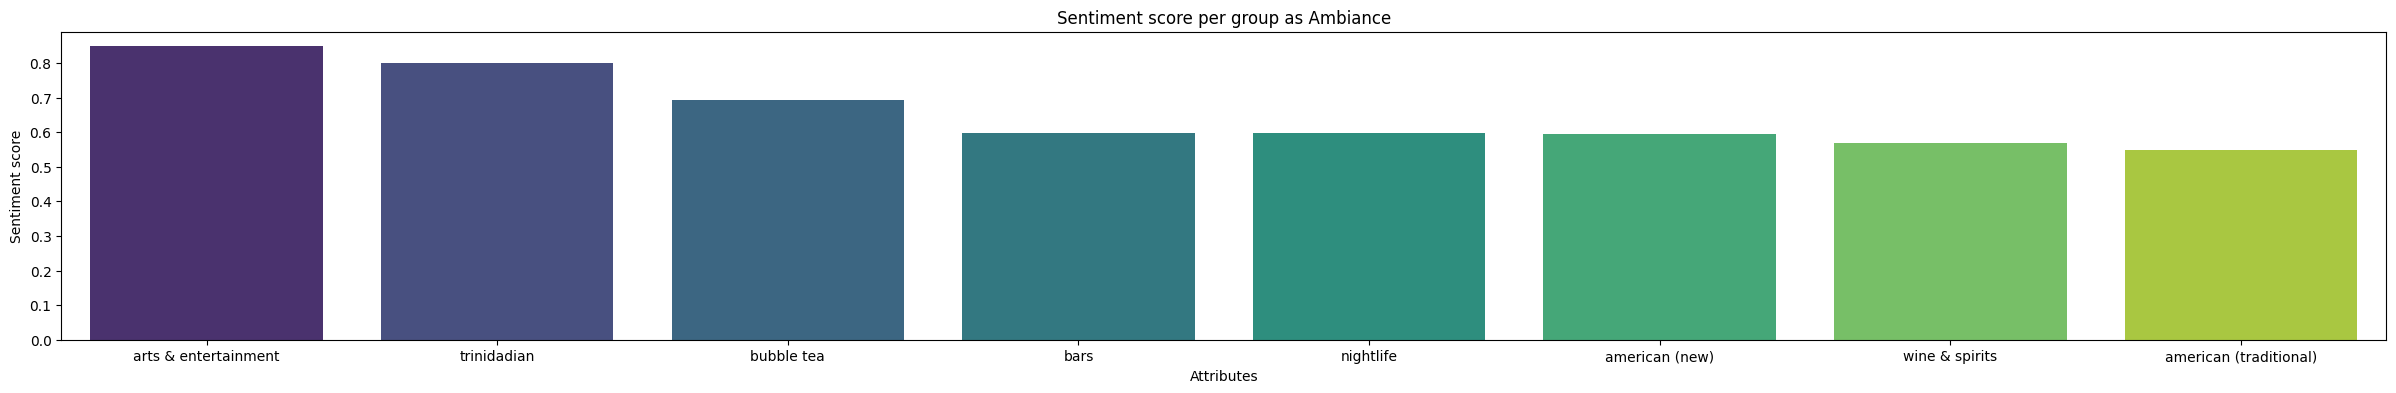

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


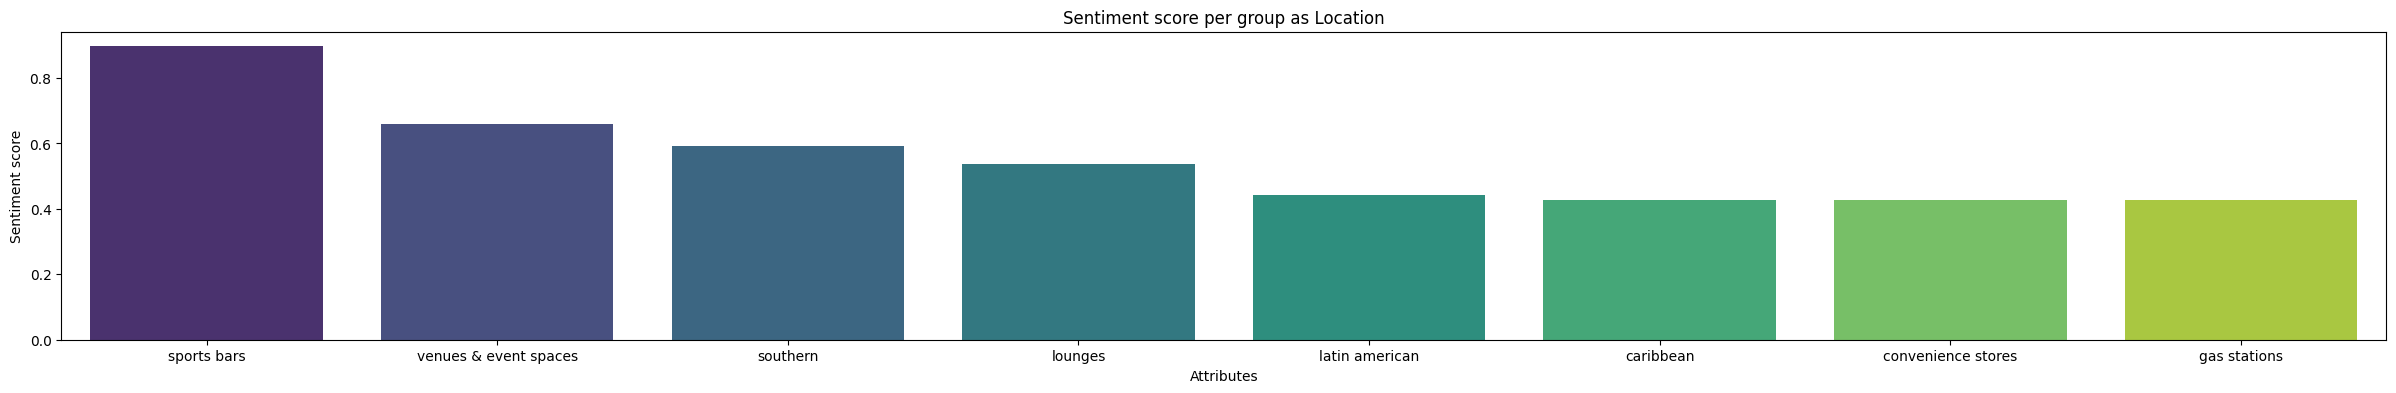

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


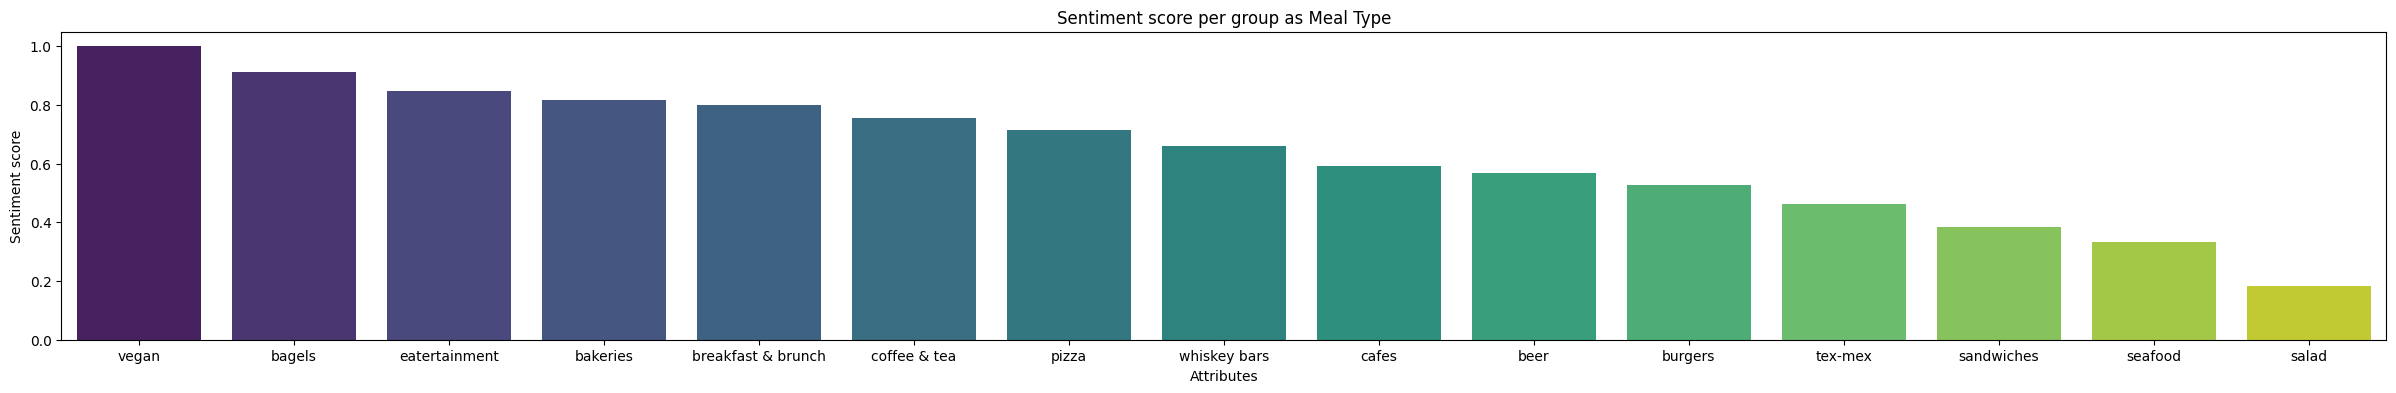

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


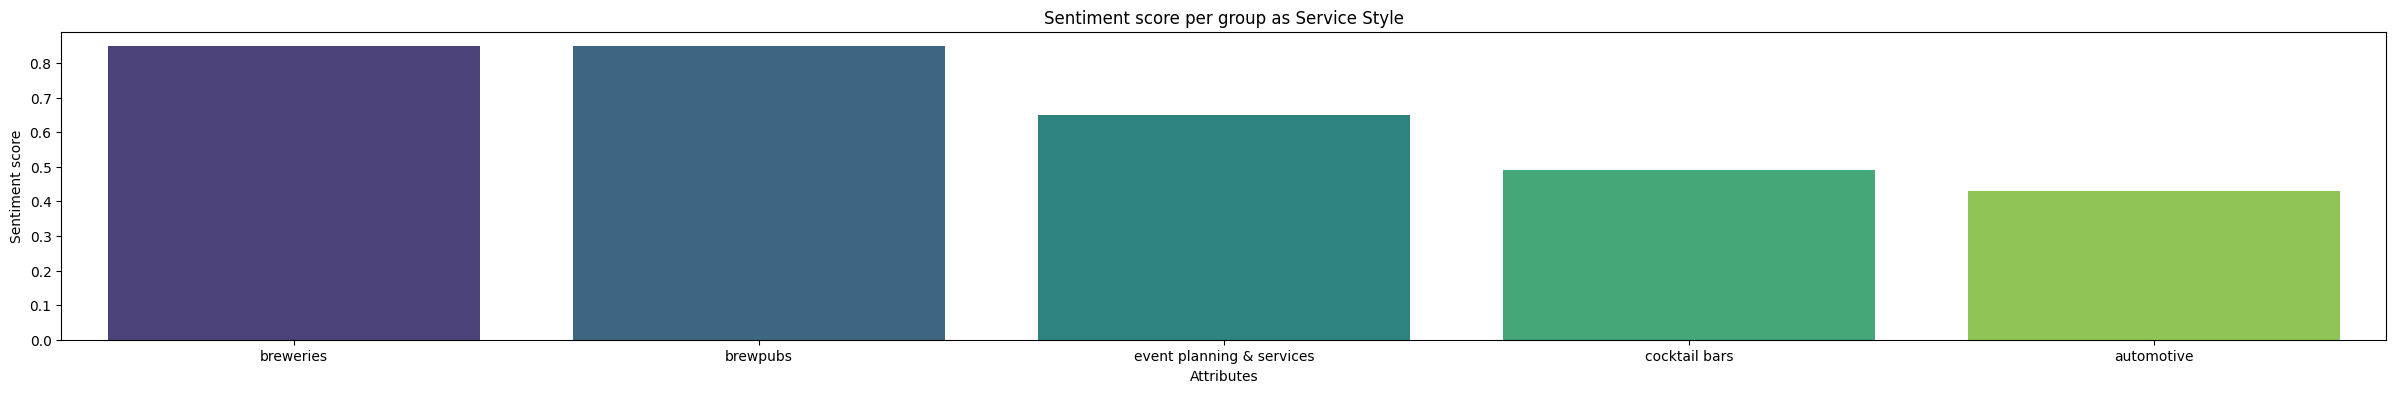

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


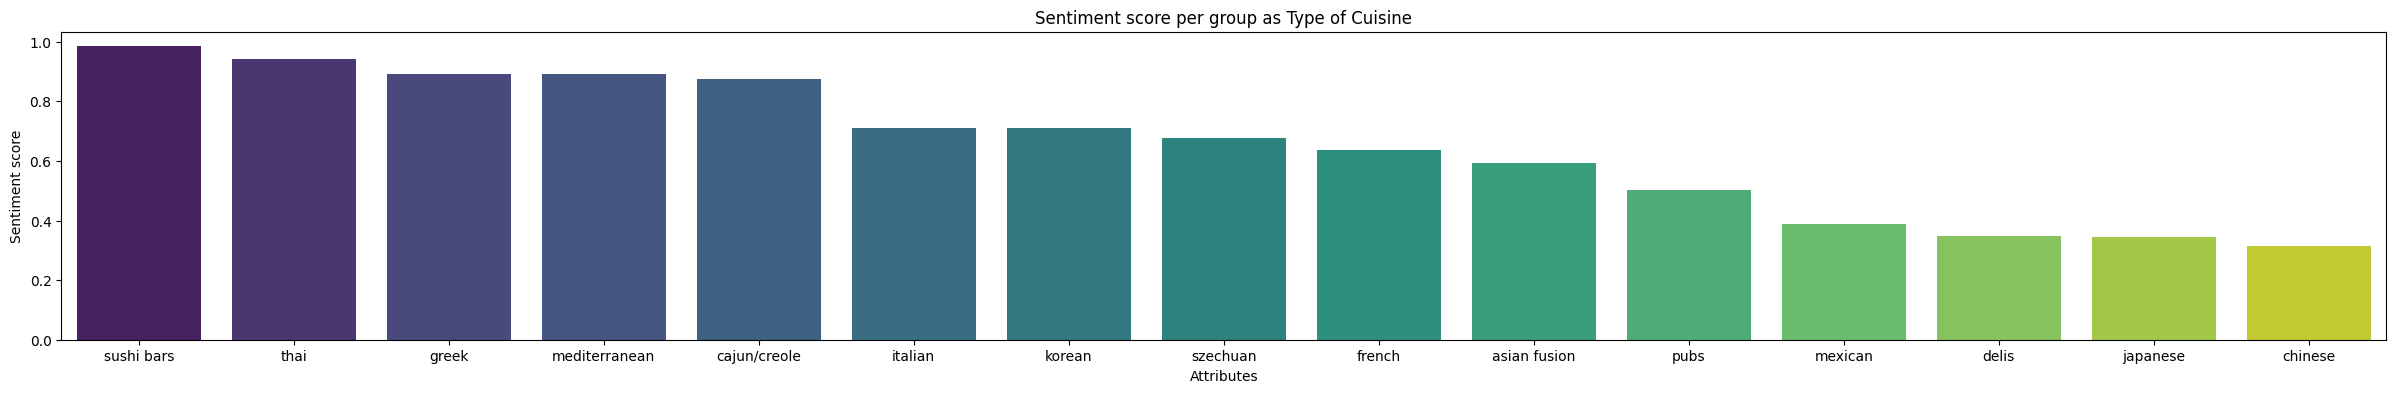

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("NEGATIVE", 0)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("POSITIVE", 1)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:46: FutureWarning: 

Passing `palette` wit

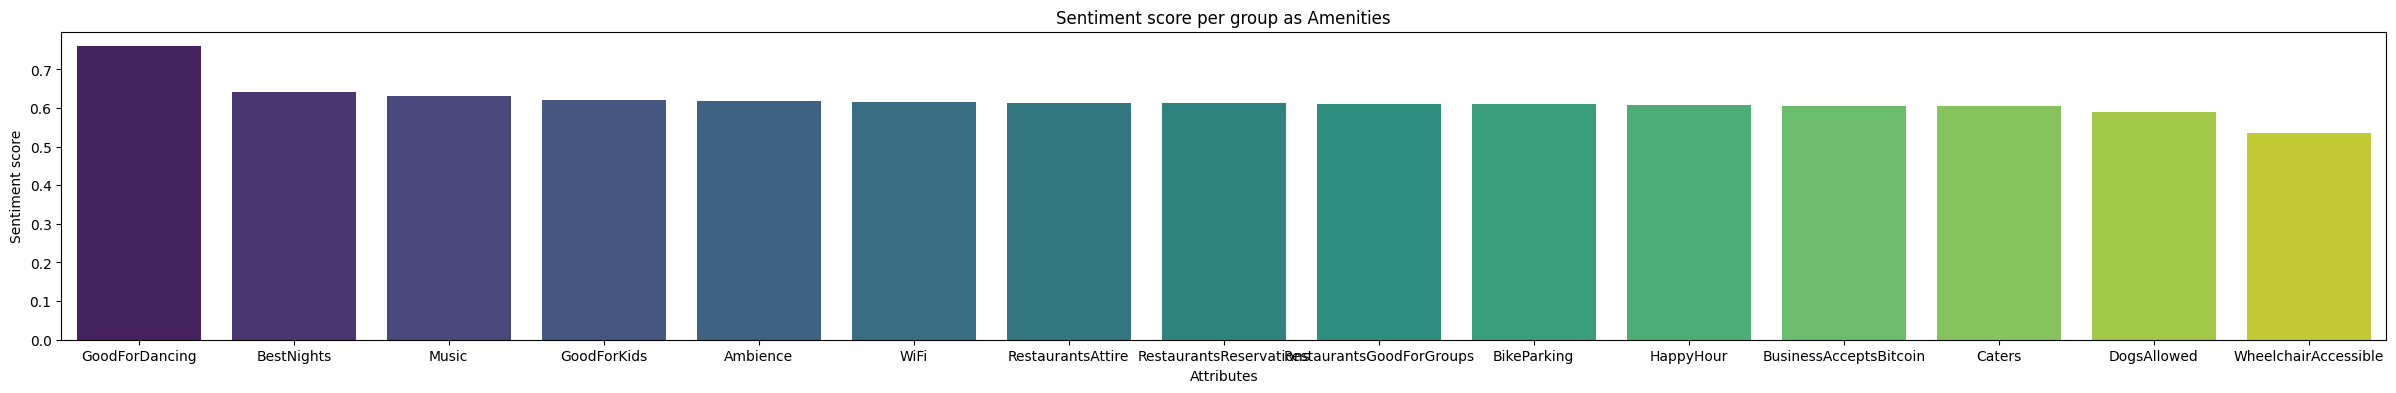

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


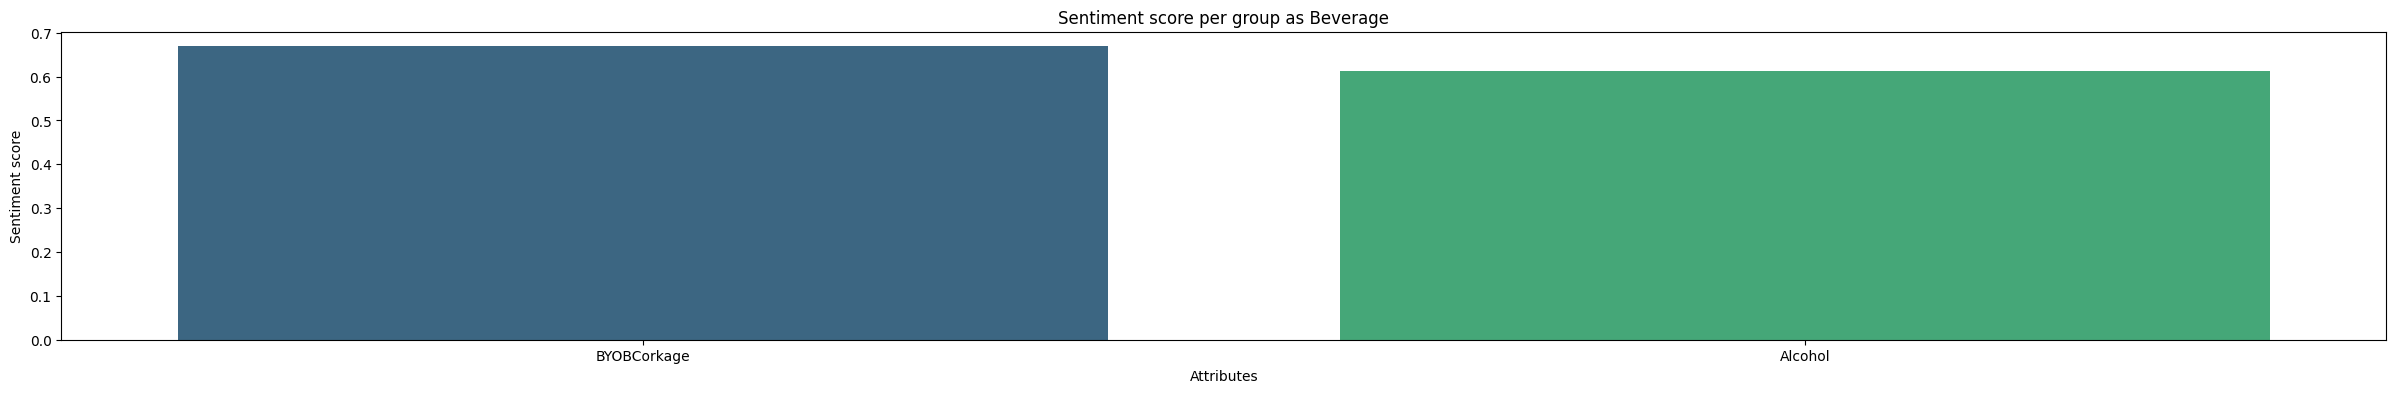

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


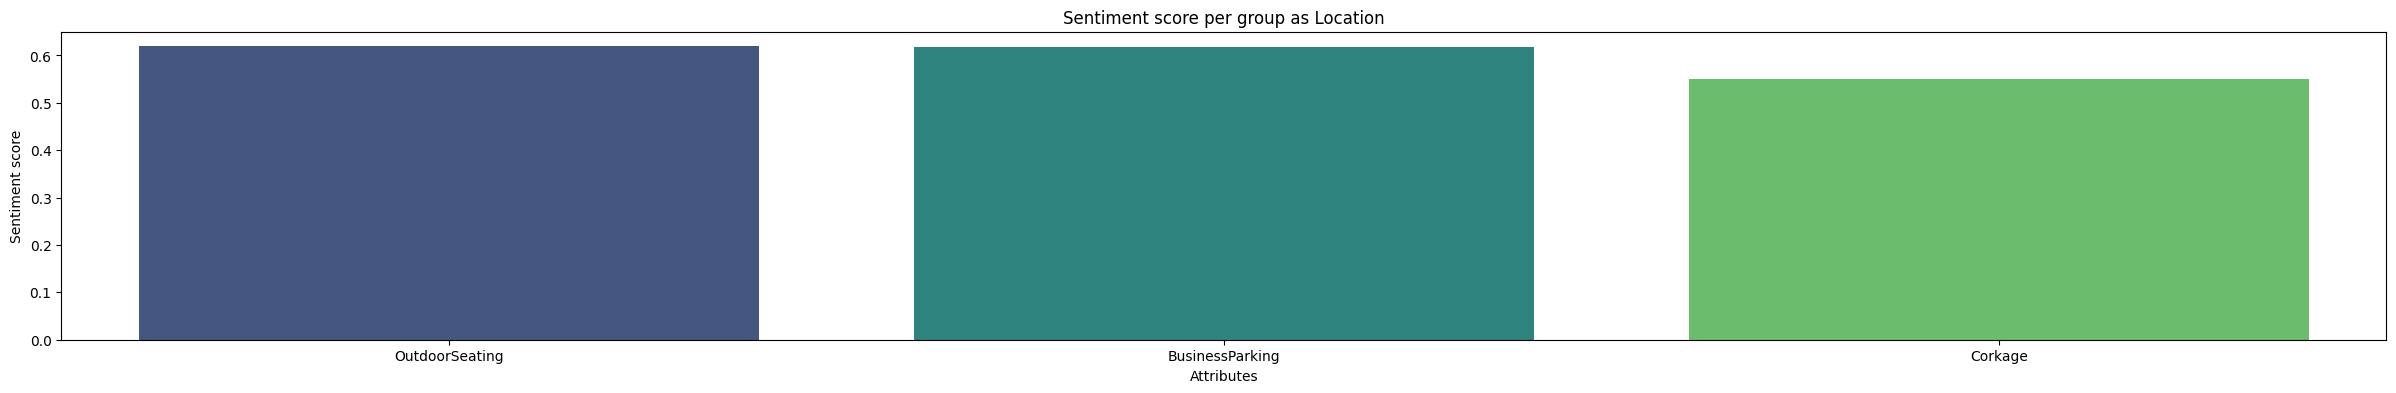

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


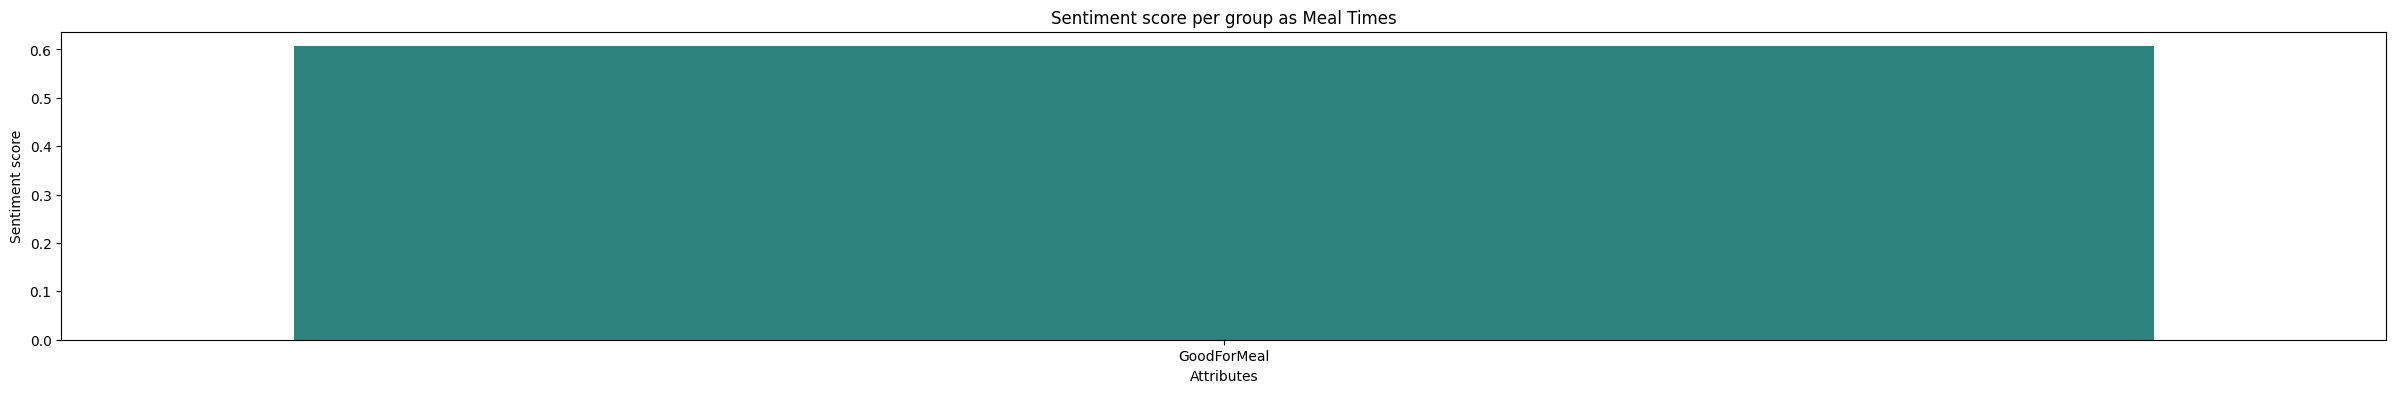

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


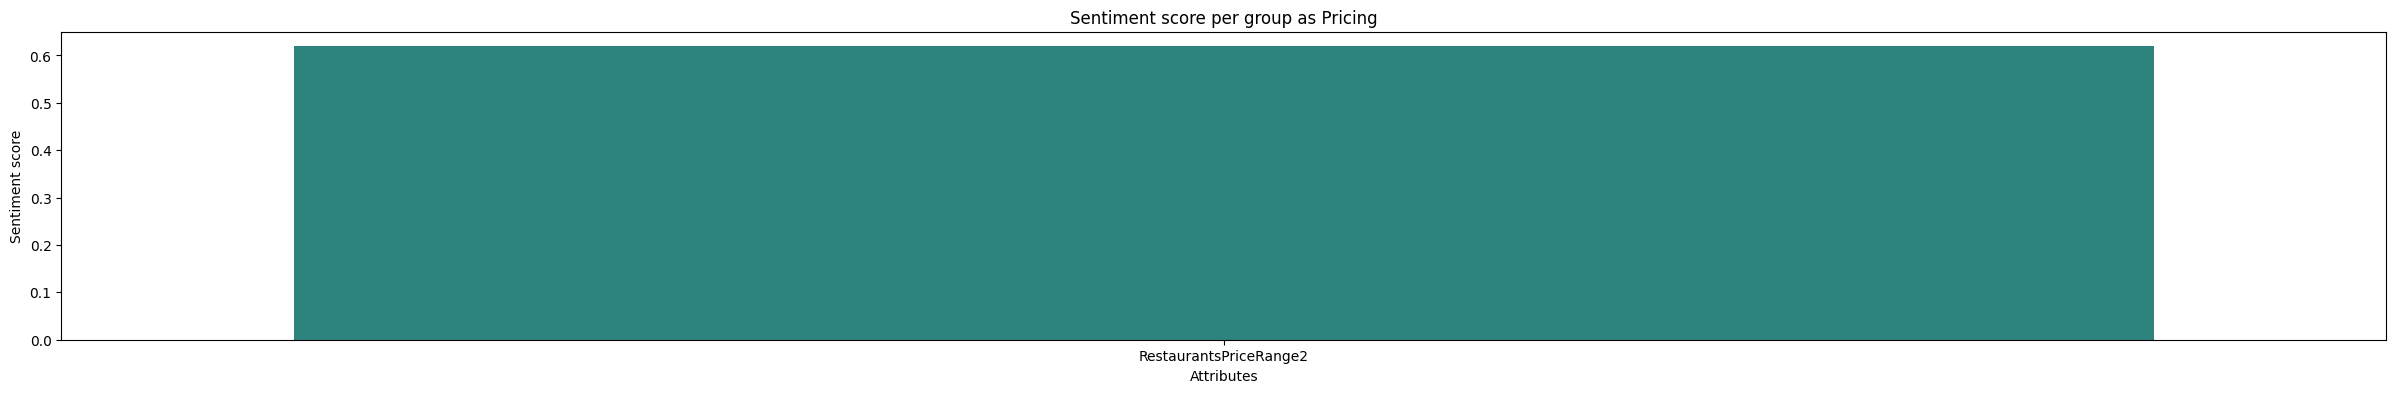

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


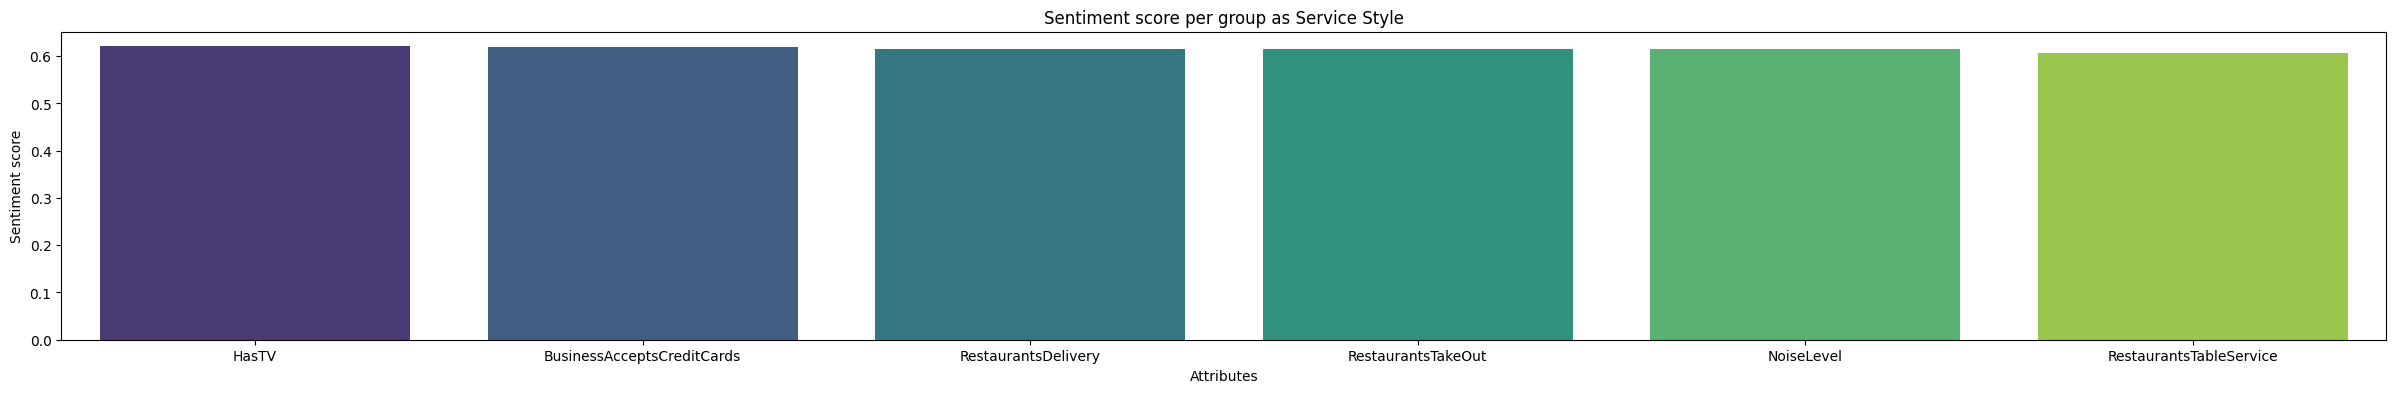

In [173]:
##################################################################
# Compute a mean sentiment score per category
df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("NEGATIVE", 0)
df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("POSITIVE", 1)

# Replicate observations based on "useful"
df_UserQuality_cat = df_UserQuality_cat.loc[np.repeat(df_UserQuality_cat.index, df_UserQuality_cat["useful"])].reset_index()

mean_sent_category = df_UserQuality_cat.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)

# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Sentiment score")
    plt.show()


##################################################################
# Compute a mean sentiment per attribute
df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("NEGATIVE", 0)
df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("POSITIVE", 1)

# Replicate observations based on "useful"
df_useful_attribute = df_UserQuality_atr.loc[np.repeat(df_UserQuality_atr.index, df_UserQuality_atr["useful"])].reset_index()

mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["sentiment"].mean().reset_index()
mean_sent_attribute.sort_values(by="sentiment", ascending=False)
mean_sent_attribute

# Barplots per attribute and sentiment
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Sentiment score")
    plt.show()

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


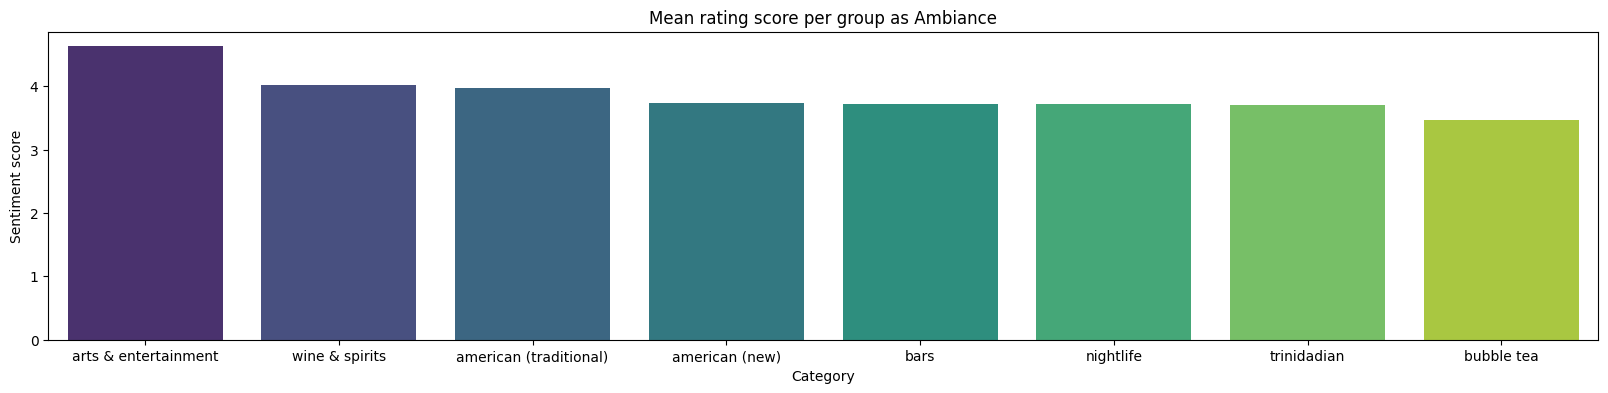

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


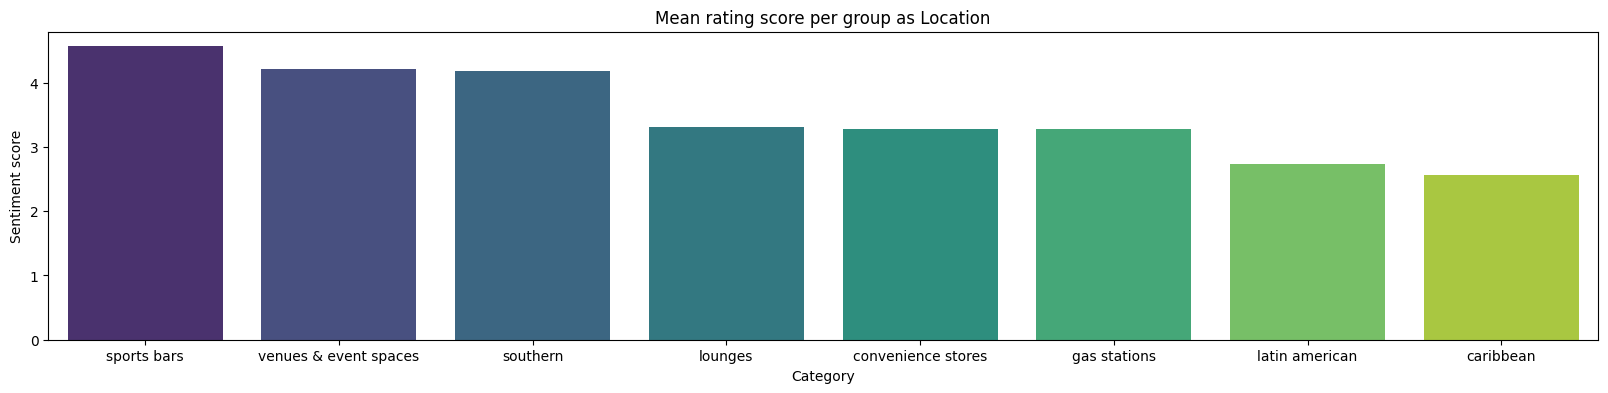

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


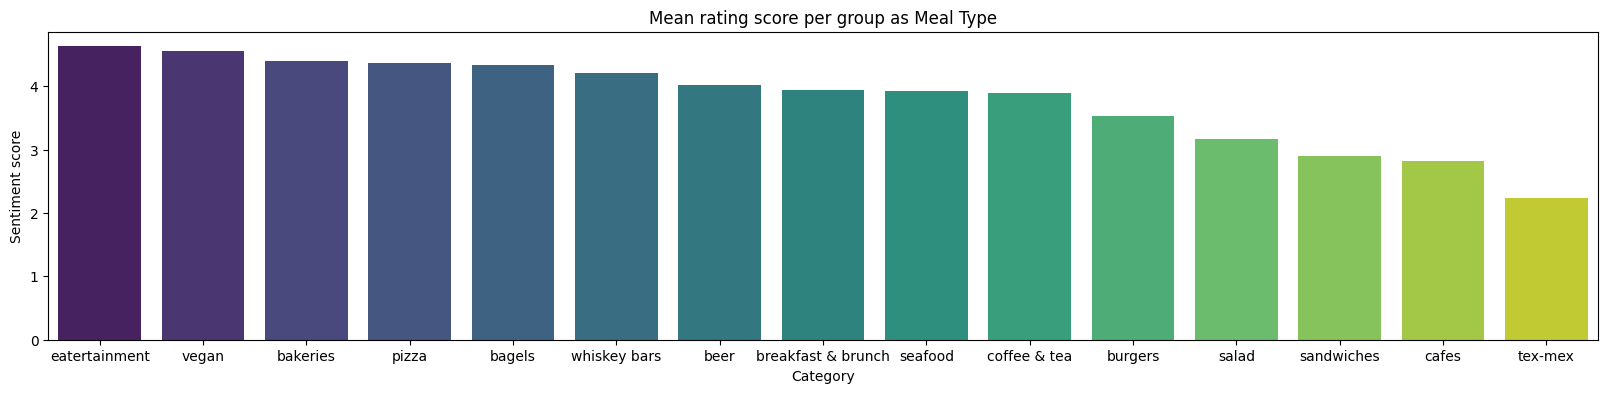

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


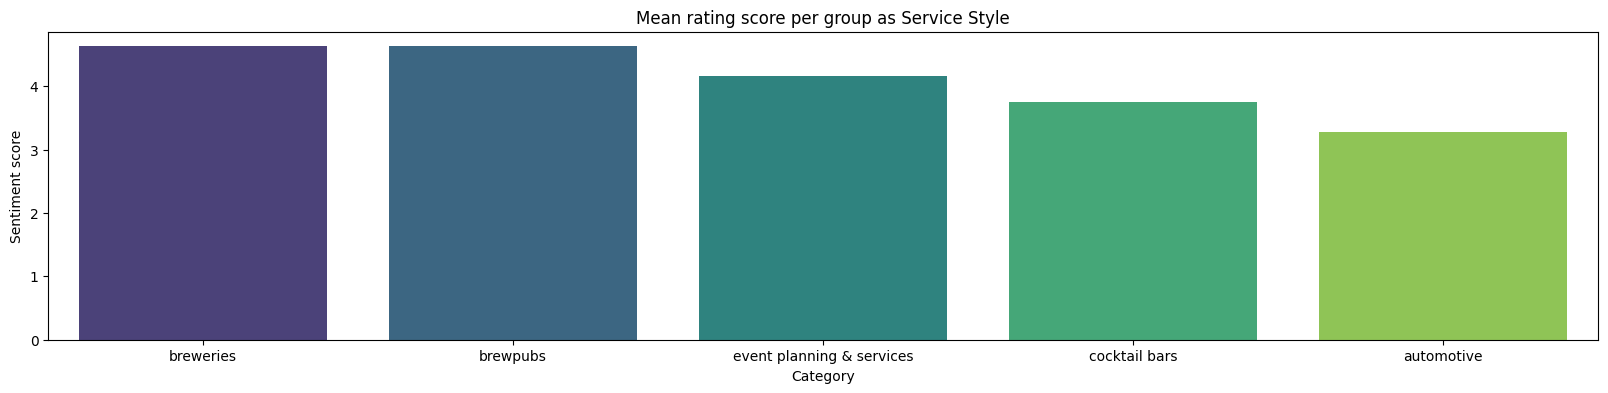

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


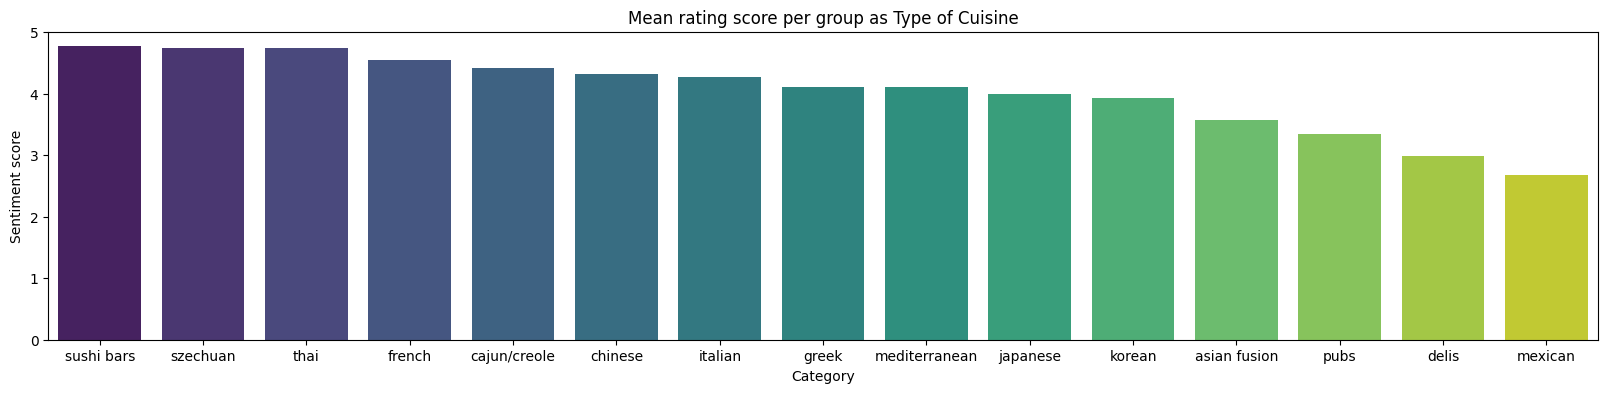

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


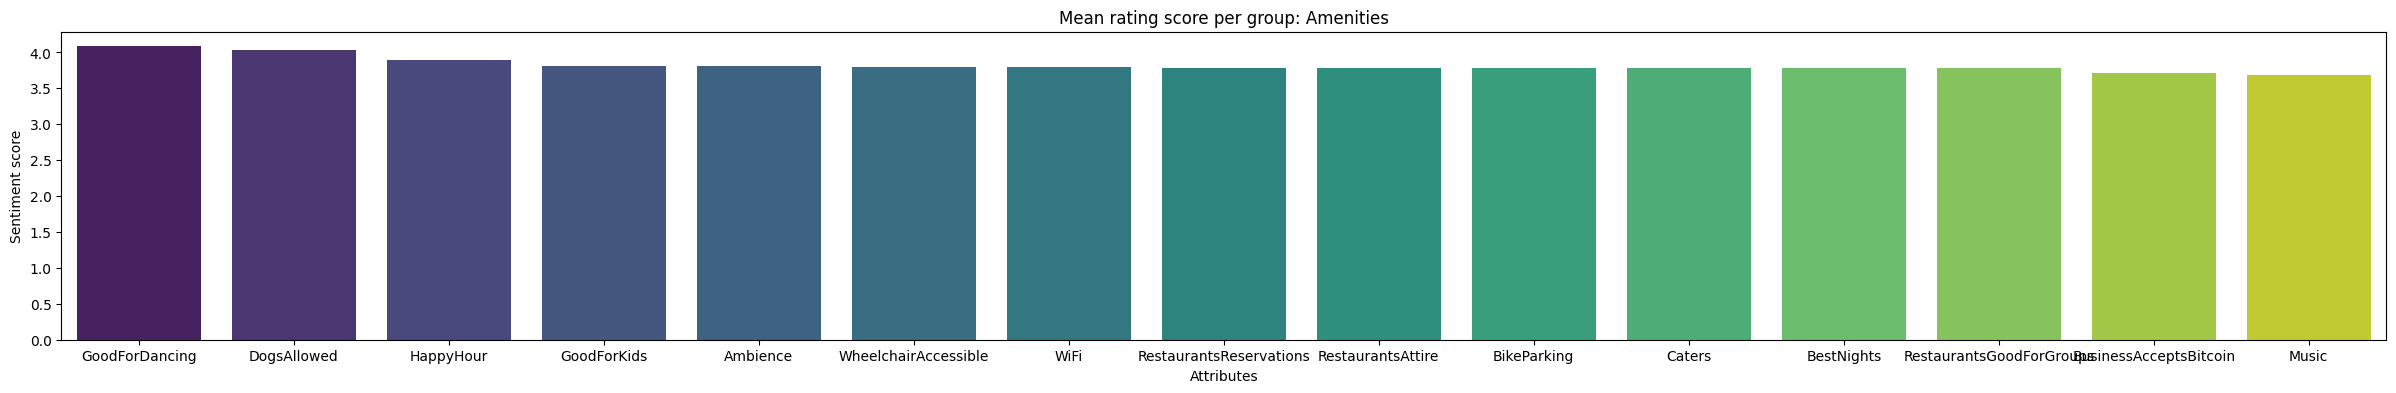

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


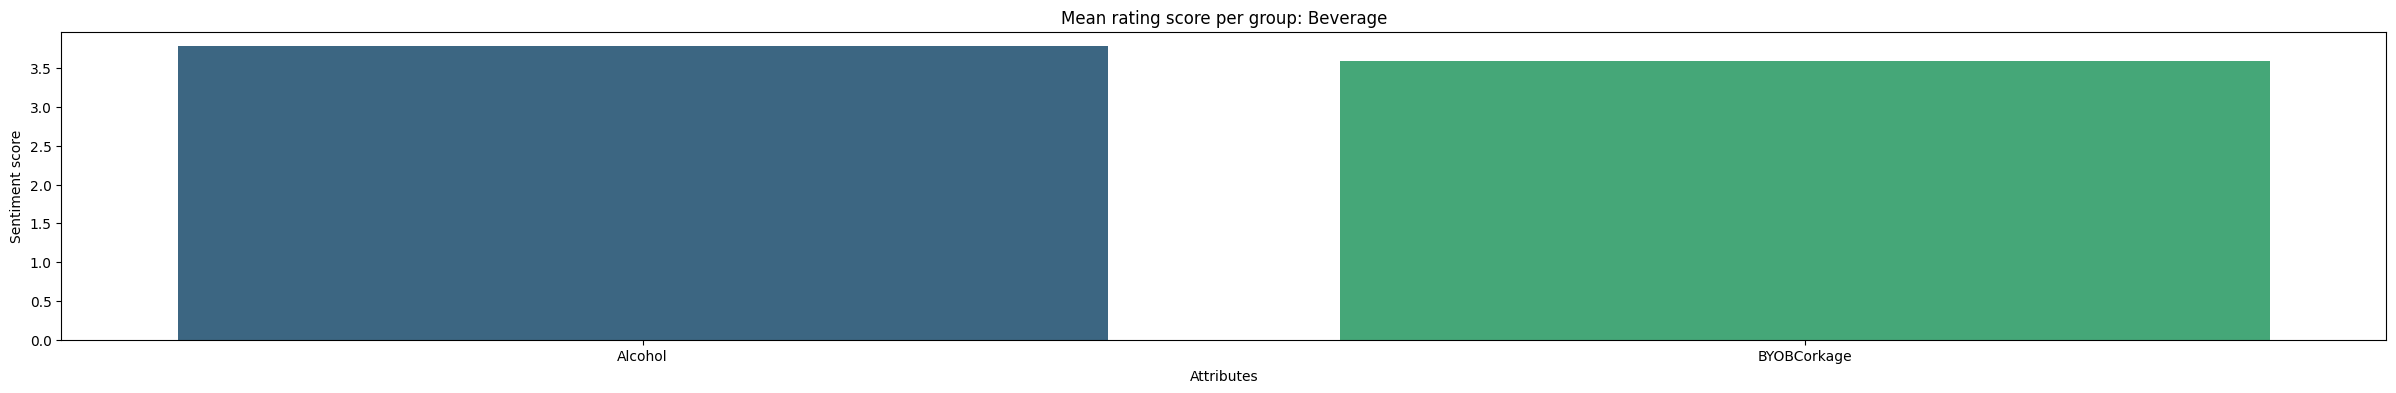

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


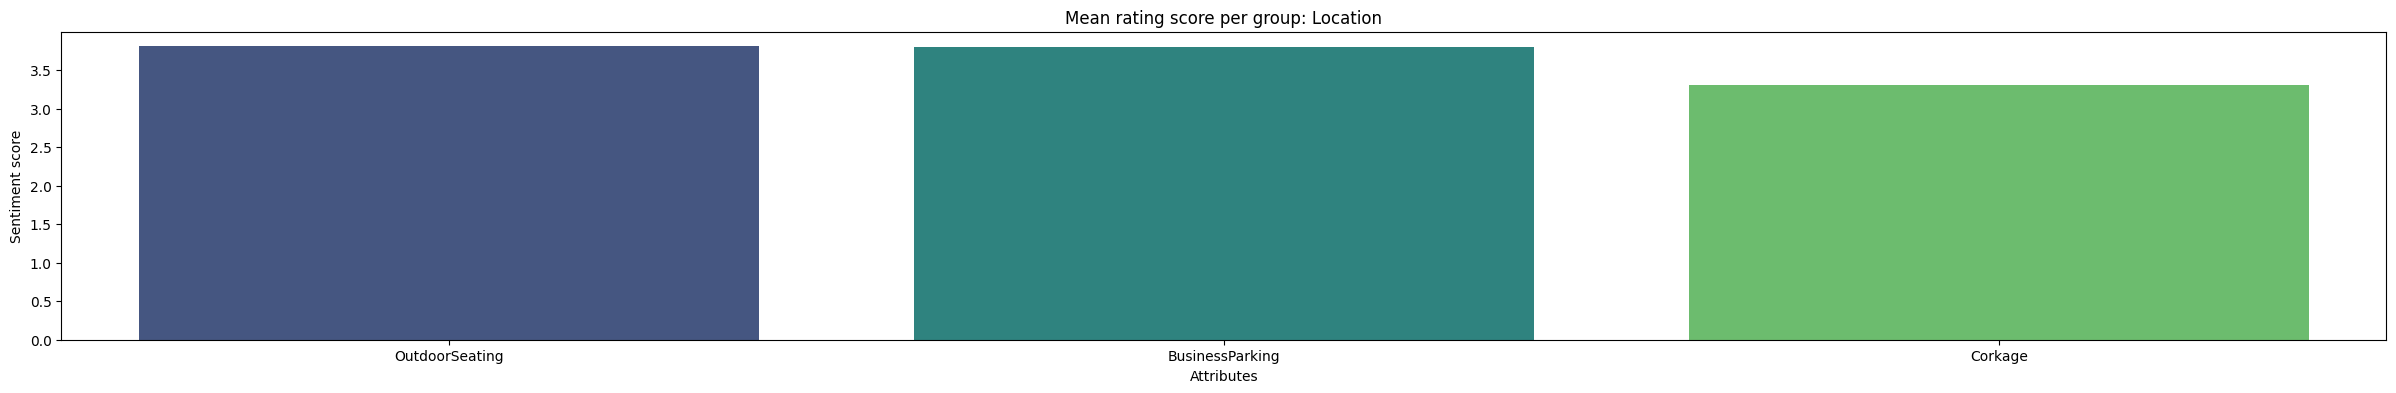

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


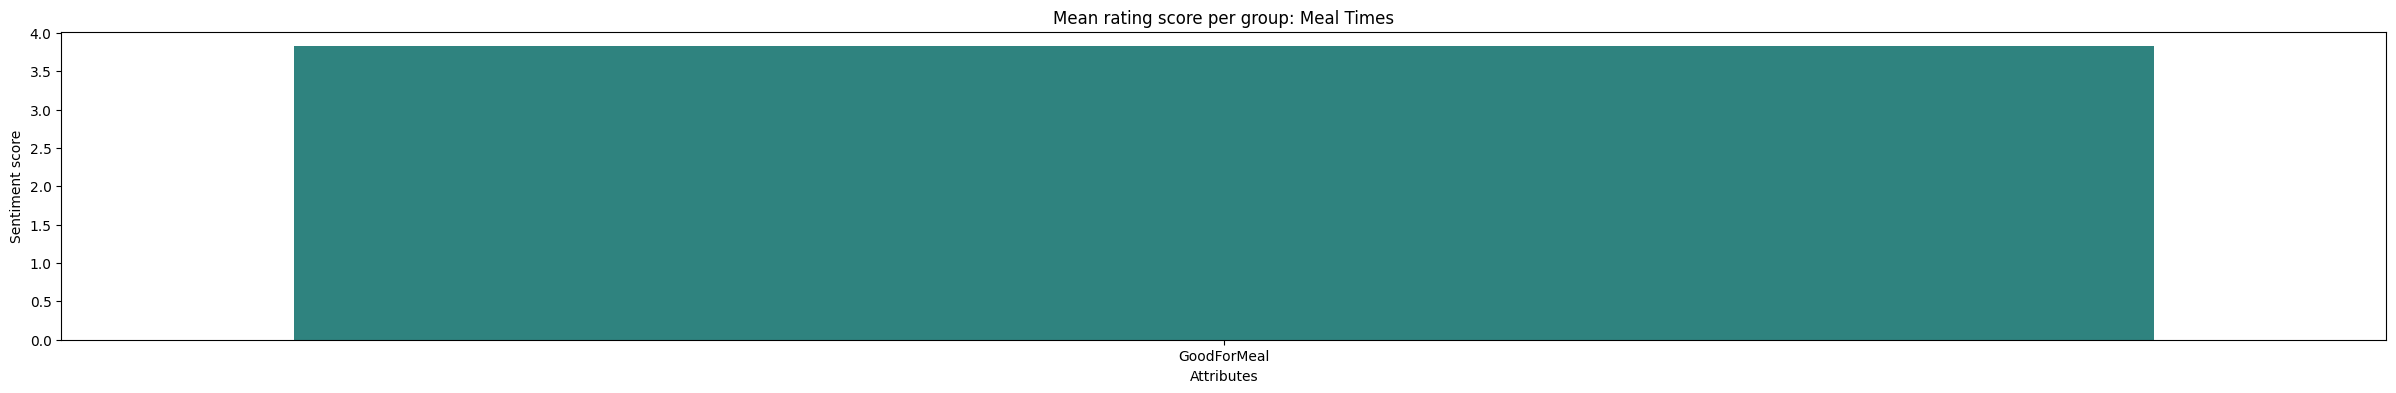

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


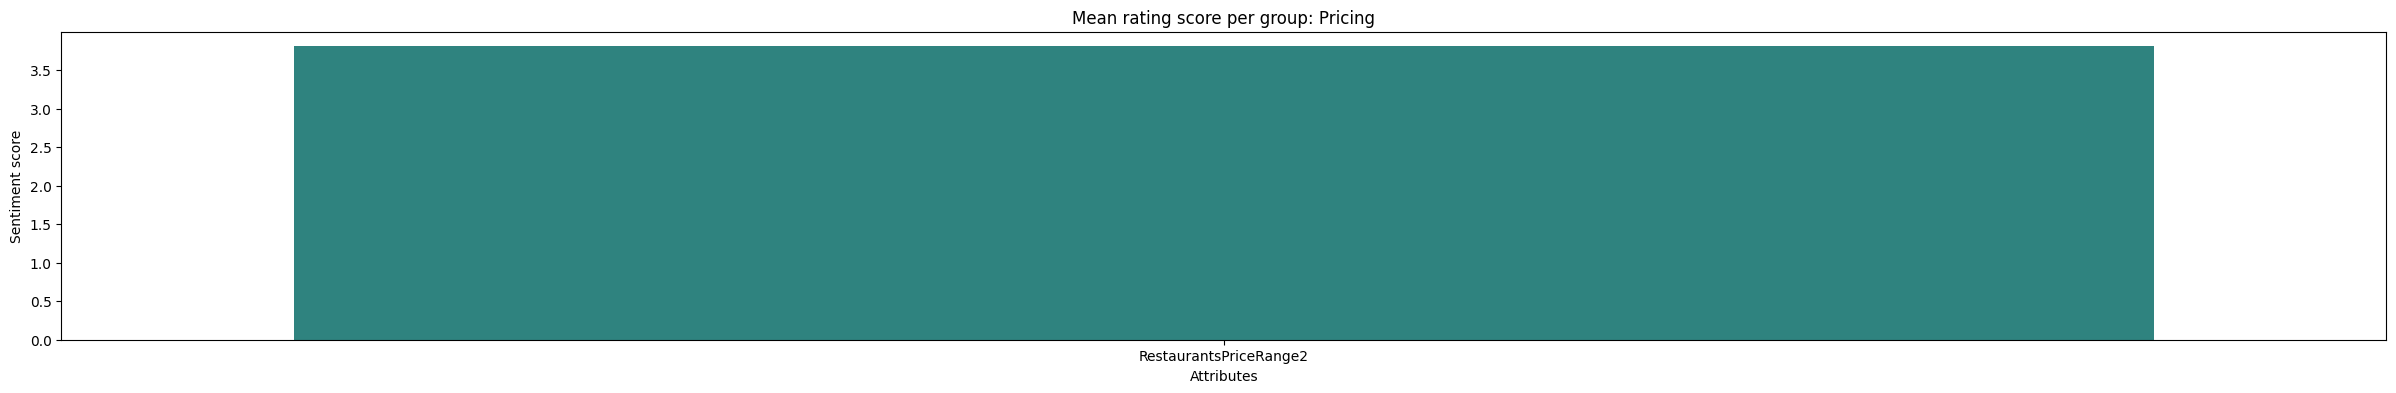

C:\Users\Alexis\AppData\Local\Temp\ipykernel_5944\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


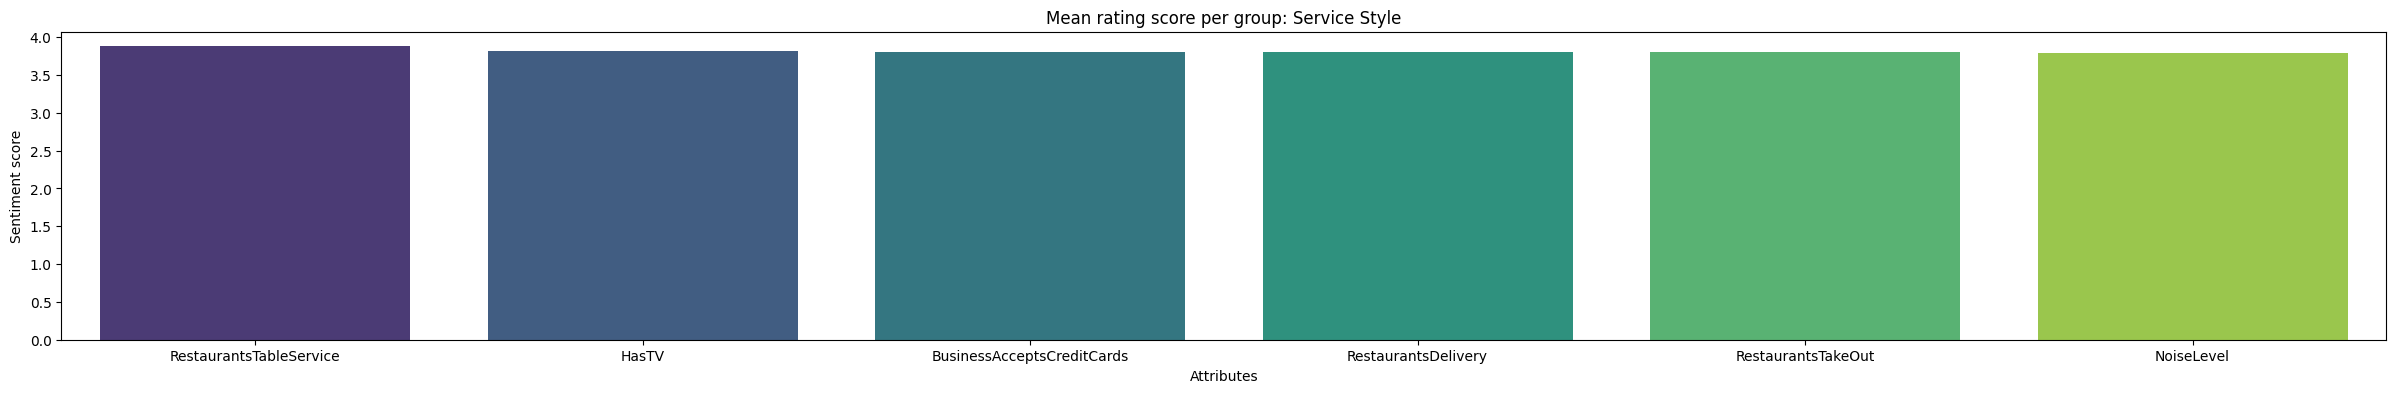

In [174]:
# Compute a mean rating score per category
mean_sent_category = df_UserQuality_cat.groupby(["group_categorie", "categories_list"])["rating"].mean().reset_index()
mean_sent_category.sort_values(by="rating", ascending=False)

# Barplots per category and rating
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(20, 4))
    plt.title(f"Mean rating score per group as {group}")
    sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment score")
    plt.show()


# Compute a mean rating per attribute
mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["rating"].mean().reset_index()
mean_sent_attribute.sort_values(by="rating", ascending=False)

# Barplots per category and rating
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Mean rating score per group: {group}")
    sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Sentiment score")
    plt.show()

# 2.2
## An analysis of the evolution of food trends in the area over time, in terms of consumer preferences. Do the preferences evolve over time, or do they seem stable?

# 2.3
## Imagine you have to present your findings to the business owner and his investors. What advice would you give to the new business, based on your findings?

### TO DO: Find the most frequent and worse ratings ( negative feeling) per attribute and category. 

We can interpret negativity as frustration and unfulfilled needs. As a result, there"s a chance to be successful in the restaurant business by satisfying unfulfilled needs, and consequently to do good business. To maximize your chances of success, you need to target what most consumers are saying. That"s why we need to identify what is particularly misjudged in Philadelphia.

Our analysis has shown that the Philadelphia restaurant market: [Findings]...
1. General across years
2. Trend analysis + evolution
    1. What is stable VS unstable ?
    2. What is recent ?

We recommend to the business owner and his investors: [Practically / Business insight]